<a href="https://colab.research.google.com/github/thc1006/flora-dp-federated-ColO-RAN/blob/main/0707_FLORA_DP_client_15_v1_1_0(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Cell 1: Áí∞Â¢ÉË®≠ÂÆöËàáÂáΩÂºèÂ∫´ÂåØÂÖ•ÔºàÂº∑ÂåñÁâàÔºâ
# ‰øÆÊ≠£ÔºöÂÆâË£ù nest_asyncio
!pip install --upgrade opacus -q
!pip install nest_asyncio -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader
from typing import Dict, List, Tuple, Optional, Union
import scipy.stats as stats
from datetime import datetime
import nest_asyncio # ‰øÆÊ≠£ÔºöÂåØÂÖ• nest_asyncio

# --- Áí∞Â¢ÉË®≠ÂÆö ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

# --- Êñ∞Â¢ûÔºöDeterministic Ë®≠ÂÆö (‰ªªÂãô6) ---
def set_global_seed(seed: int = 42):
    """Ë®≠ÂÆöÂÖ®Â±ÄÈö®Ê©üÁ®ÆÂ≠ê‰ª•Á¢∫‰øùÂèØÈáçÁèæÊÄß"""
    # ‰øÆÊ≠£ÔºöË®≠ÂÆö CUBLAS_WORKSPACE_CONFIG Áí∞Â¢ÉËÆäÊï∏
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Á¢∫‰øù deterministic Ë°åÁÇ∫
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if hasattr(torch, 'use_deterministic_algorithms'):
        try:
            torch.use_deterministic_algorithms(True)
        except RuntimeError:
            # Êüê‰∫õÊìç‰ΩúÂèØËÉΩ‰∏çÊîØÊè¥ deterministic
            print("‚ö†Ô∏è ÈÉ®ÂàÜÊìç‰Ωú‰∏çÊîØÊè¥ÂÆåÂÖ® deterministic Ê®°Âºè")

set_global_seed(42)

# ‰øÆÊ≠£ÔºöÊáâÁî® nest_asyncio
nest_asyncio.apply()

print("‚úÖ Cell 1: Áí∞Â¢ÉËàáÂáΩÂºèÂ∫´Ê∫ñÂÇôÂ∞±Á∑íÔºàÂê´ Deterministic Ëàá Asyncio ‰øÆÊ≠£Ôºâ„ÄÇ")
import opacus
print(f"PyTorch/Opacus ÁâàÊú¨: {torch.__version__} / {opacus.__version__}")
print(f"CUDA ÊòØÂê¶ÂèØÁî®: {torch.cuda.is_available()}")
print(f"Deterministic Ê®°Âºè: Â∑≤ÂïüÁî®")
print(f"Nest Asyncio: Â∑≤ÊáâÁî®")

‚úÖ Cell 1: Áí∞Â¢ÉËàáÂáΩÂºèÂ∫´Ê∫ñÂÇôÂ∞±Á∑íÔºàÂê´ Deterministic Ëàá Asyncio ‰øÆÊ≠£Ôºâ„ÄÇ
PyTorch/Opacus ÁâàÊú¨: 2.6.0+cu124 / 1.5.4
CUDA ÊòØÂê¶ÂèØÁî®: True
Deterministic Ê®°Âºè: Â∑≤ÂïüÁî®
Nest Asyncio: Â∑≤ÊáâÁî®


In [ ]:
# @title Cell 2: üéì ÂØ¶È©óÂèÉÊï∏Ë®≠ÂÆöÔºàÂº∑ÂåñÁâà - ÊîØÊè¥ Non-IID & CQLÔºâ
from dataclasses import dataclass, field
import os
import json
import torch
import numpy as np
from typing import Tuple

@dataclass
class TrainingConfig:
    experiment_name: str
    output_dir: str
    mode: str = "ClusteredFL"  # Êñ∞Â¢ûÊîØÊè¥: "CQL"
    random_seed: int = 42
    comm_rounds: int = 20

    # „ÄêÊñ∞Â¢û„ÄëNon-IID ÈÖçÁΩÆ (‰ªªÂãô1)
    enable_non_iid: bool = True
    dirichlet_alpha: float = 0.5  # ÊéßÂà∂ Non-IID Á®ãÂ∫¶ÔºåË∂äÂ∞èË∂äÁï∞Ë≥™
    min_clients_non_iid: int = 10  # ÊúÄÂ∞ëÂÆ¢Êà∂Á´ØÊï∏Èáè

    # „ÄêÊñ∞Â¢û„ÄëCQL ÈÖçÁΩÆ (‰ªªÂãô2)
    enable_cql: bool = False
    cql_alpha: float = 1.0  # CQL ‰øùÂÆàÊÄßÊ¨äÈáç
    cql_min_q_weight: float = 5.0  # ÊúÄÂ∞è Q ÂÄºÊá≤ÁΩ∞Ê¨äÈáç

    # „ÄêÊñ∞Â¢û„ÄëAdaptive Clipping ÈÖçÁΩÆ (‰ªªÂãô3)
    enable_adaptive_clip: bool = True
    clip_window: int = 50  # Áµ±Ë®àÁ™óÂè£Â§ßÂ∞è
    clip_percentile: float = 0.9  # ‰ΩøÁî® 90 ÂàÜ‰ΩçÊï∏

    # „ÄêÊñ∞Â¢û„ÄëÈùûÂêåÊ≠•ËÅöÂêàÈÖçÁΩÆ (‰ªªÂãô4)
    enable_async_aggregation: bool = True
    timeout_threshold: float = 0.3  # 30% ÂÆ¢Êà∂Á´ØË∂ÖÊôÇËß∏ÁôºÈùûÂêåÊ≠•
    client_timeout_seconds: float = 30.0  # ÂÆ¢Êà∂Á´ØË∂ÖÊôÇÊôÇÈñì

    # ËôõÊì¨ÂÆ¢Êà∂Á´ØÁõ∏ÈóúÔºà‰øùÁïôÂéüÊúâÔºâ
    base_client_pairs: tuple = ((1, 2), (3, 7), (5, 6))
    virtual_expansion_factor: int = 3
    num_virtual_clients: int = 9
    num_real_clients: int = 3
    total_clients: int = 12
    num_clients: int = 12
    num_clients_to_select: int = 8

    # ÂÖ∂‰ªñÂéüÊúâÂèÉÊï∏‰øùÊåÅ‰∏çËÆä
    temporal_split_method: str = "sliding_window"
    noise_injection_std: float = 0.03
    feature_augmentation: bool = True
    cross_validation_split: bool = True

    local_episodes_per_round: int = 4
    steps_per_episode: int = 500
    batch_size: int = 256
    gamma: float = 0.99

    lr: float = 1e-4
    target_update_freq: int = 15

    epsilon_start: float = 1.0
    epsilon_decay: float = 0.9995
    epsilon_min: float = 0.05

    memory_capacity: int = 50000
    replay_start_size: int = 1000
    replay_frequency: int = 2
    replay_batches_per_call: int = 3

    fedprox_mu: float = 0.15
    num_clusters: int = 3
    cluster_update_freq: int = 8

    enable_dp: bool = True
    dp_target_epsilon: float = 8.0
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 1.0
    dp_noise_multiplier: float = 0.5
    dp_sampling_probability: float = 0.1
    dp_virtual_batch_size: int = 256
    dp_microbatch_size: int = 1

    dp_reset_threshold_multiplier: float = 1.5
    enable_dp_reset: bool = True

    enable_heterogeneity: bool = True
    enable_compression: bool = True

    straggler_ratio: float = 0.1
    dropout_ratio: float = 0.05
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True
    local_finetune_episodes: int = 15
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    client_pairs: tuple = field(init=False)

    def __post_init__(self):
        # ÂãïÊÖãÁîüÊàêÂÆ¢Êà∂Á´ØÈÖçÂ∞ç
        extended_client_pairs = []
        for i in range(self.total_clients):
            embb_id = i + 1
            urllc_id = i + 2
            extended_client_pairs.append((embb_id, urllc_id))
        self.client_pairs = tuple(extended_client_pairs)

        # GPU Áí∞Â¢ÉÊ™¢Ê∏¨
        if torch.cuda.is_available():
            if "L4" in torch.cuda.get_device_name(0):
                print(f"üöÄ L4 GPUÊ™¢Ê∏¨Âà∞ÔºåÂïüÁî®Â§ßÊâπÊ¨°ÂÑ™ÂåñÈÖçÁΩÆ")

        # Â∑ÆÂàÜÈö±ÁßÅÊ®°ÂºèÊ™¢Ê∏¨
        if self.mode == 'Centralized':
            self.enable_dp = False

        # CQL Ê®°ÂºèÊ™¢Ê∏¨
        if self.mode == 'CQL':
            self.enable_cql = True
            print(f"üéØ CQL Ê®°ÂºèÂïüÁî® - Œ±={self.cql_alpha}, min_q_weight={self.cql_min_q_weight}")

        # ÈÖçÁΩÆ‰ø°ÊÅØÈ°ØÁ§∫
        print(f"üîÑ ÂØ¶È©óÈÖçÁΩÆ:")
        print(f"   - Non-IID: {'ÂïüÁî®' if self.enable_non_iid else 'Á¶ÅÁî®'} (Œ±={self.dirichlet_alpha})")
        print(f"   - Adaptive Clipping: {'ÂïüÁî®' if self.enable_adaptive_clip else 'Á¶ÅÁî®'}")
        print(f"   - ÈùûÂêåÊ≠•ËÅöÂêà: {'ÂïüÁî®' if self.enable_async_aggregation else 'Á¶ÅÁî®'}")
        print(f"   - Á∏ΩÂÆ¢Êà∂Á´ØÊï∏: {self.total_clients}")

        if self.enable_dp and self.mode != 'Centralized':
            print(f"üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÂ∑≤ÂïüÁî®")
            print(f"   - ÁõÆÊ®ôÈö±ÁßÅÈ†êÁÆó: Œµ={self.dp_target_epsilon}")
            print(f"   - ÊâπÊ¨°Â§ßÂ∞è: {self.batch_size}")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in self.__dict__.items()}
        with open(path, 'w') as f:
            json.dump(config_dict, f, indent=4)
        print(f"‚úÖ ÈÖçÁΩÆÂ∑≤‰øùÂ≠òËá≥: {path}")

print("‚úÖ Cell 2: TrainingConfigÔºàÂº∑ÂåñÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 2: TrainingConfigÔºàÂº∑ÂåñÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 3: üß© Êï∏ÊìöËàáÁí∞Â¢ÉÊ∫ñÂÇôÔºàÊîØÊè¥ Non-IID ÂàÜÈÖçÔºâ
class DataManager:
    def __init__(self, data_path, client_pairs_config, enable_non_iid=False,
                 dirichlet_alpha=0.5, min_clients=10):
        print(f"\n[DataManager] Ê≠£Âú®Âæû {data_path} ËÆÄÂèñÊï∏Êìö...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self.enable_non_iid = enable_non_iid
        self.dirichlet_alpha = dirichlet_alpha
        self.min_clients = min_clients
        self._sanitize_column_names()
        self._preflight_check()

    def _sanitize_column_names(self):
        sanitized_columns = [re.sub(r'[\\[\\]\\(\\)%\\s\\.-]+', '_', col.strip().lower()).strip('_')
                           for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager ÂïüÂãïÂâçÈ†êÊ™¢Êü• " + "="*20)
        cols = self.df_kpi.columns.tolist()
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± {len(cols)} ÂÄã):")
        print(f"   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: '{self.tput_col}'" if self.tput_col
              else "   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÂåπÈÖçÂ§±ÊïóÔºÅ")
        print(f"   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: '{self.lat_col}'" if self.lat_col
              else "   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÂåπÈÖçÂ§±ÊïóÔºÅ")

        available_bs = sorted(self.df_kpi['bs_id'].unique())
        print(f"   - ÂèØÁî®BSÁØÄÈªû: {available_bs}")
        print("="*65 + "\n")

        if not (self.tput_col and self.lat_col):
            raise ValueError("È†êÊ™¢Êü•Â§±Êïó: Êâæ‰∏çÂà∞ÂøÖË¶ÅÁöÑÊï∏ÊìöÊ¨Ñ‰Ωç„ÄÇ")

    def _get_clean_df(self, gnb_id, slice_id):
        """Áç≤ÂèñÊ∏ÖÁêÜÂæåÁöÑÊï∏Êìö"""
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'

        mask = (df[bs_col].astype(int) == int(gnb_id)) & (df[sl_col].astype(int) == int(slice_id))
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()

        subset = subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'})
        subset = subset.dropna()

        if not subset.empty:
            subset = subset[
                (subset['throughput'] >= 0) & (subset['throughput'] <= 1000) &
                (subset['latency'] >= 0) & (subset['latency'] <= 1e9)
            ]

        return subset

    def _create_non_iid_distribution(self, total_data_points):
        """‰ΩøÁî® Dirichlet ÂàÜÈÖçÂâµÂª∫ Non-IID Êï∏ÊìöÂàÜÂâ≤"""
        # Á¢∫‰øùËá≥Â∞ëÊúâ min_clients ÂÄãÂÆ¢Êà∂Á´Ø
        num_clients = max(self.min_clients, len(self.client_pairs_config) * 3)

        # ‰ΩøÁî® Dirichlet ÂàÜÈÖçÁîüÊàêÂÆ¢Êà∂Á´ØÊï∏ÊìöÊØî‰æã
        proportions = np.random.dirichlet(
            alpha=[self.dirichlet_alpha] * num_clients
        )

        # Ë®àÁÆóÊØèÂÄãÂÆ¢Êà∂Á´ØÁöÑÊï∏ÊìöÈªûÊï∏
        client_data_sizes = (proportions * total_data_points).astype(int)

        # Á¢∫‰øùÊØèÂÄãÂÆ¢Êà∂Á´ØËá≥Â∞ëÊúâ‰∏Ä‰∫õÊï∏Êìö
        min_size = max(100, self.config.batch_size if hasattr(self, 'config') else 256)
        client_data_sizes = np.maximum(client_data_sizes, min_size)

        # Ë™øÊï¥Á∏ΩÂíå‰ª•ÂåπÈÖçÁ∏ΩÊï∏ÊìöÈªû
        diff = total_data_points - client_data_sizes.sum()
        if diff > 0:
            client_data_sizes[np.argmax(client_data_sizes)] += diff
        elif diff < 0:
            largest_idx = np.argmax(client_data_sizes)
            client_data_sizes[largest_idx] = max(min_size, client_data_sizes[largest_idx] + diff)

        return client_data_sizes

    def get_client_trajectories(self):
        """ÁîüÊàêÂÆ¢Êà∂Á´ØÊï∏ÊìöËªåË∑°ÔºàÊîØÊè¥ Non-IIDÔºâ"""
        if self.enable_non_iid:
            return self._get_non_iid_trajectories()
        else:
            return self._get_standard_trajectories()

    def _get_non_iid_trajectories(self):
        """ÁîüÊàê Non-IID ÂàÜ‰ΩàÁöÑÂÆ¢Êà∂Á´ØËªåË∑°"""
        print("[DataManager] Ê≠£Âú®ÁîüÊàê Non-IID ÂÆ¢Êà∂Á´ØÊï∏ÊìöÂàÜ‰Ωà...")

        # È¶ñÂÖàÊî∂ÈõÜÊâÄÊúâÂèØÁî®Êï∏Êìö
        all_data = []
        for embb_id, urllc_id in self.client_pairs_config:
            df_embb = self._get_clean_df(embb_id, 0)
            df_urllc = self._get_clean_df(urllc_id, 2)

            if not df_embb.empty and not df_urllc.empty:
                merged_df = pd.merge_asof(
                    df_embb.sort_values('timestamp'),
                    df_urllc.sort_values('timestamp'),
                    on='timestamp',
                    direction='backward',
                    tolerance=pd.Timedelta('100ms'),
                    suffixes=('_embb', '_urllc')
                ).dropna()

                if not merged_df.empty:
                    trajectory = merged_df[['throughput_embb', 'latency_embb',
                                          'throughput_urllc', 'latency_urllc']].to_numpy(dtype=np.float32)
                    all_data.append(trajectory)

        if not all_data:
            print("‚ùå ÁÑ°Ê≥ïÁîüÊàê Non-IID Êï∏ÊìöÔºöÊ≤íÊúâÊúâÊïàÊï∏Êìö")
            return {}

        # Âêà‰ΩµÊâÄÊúâÊï∏Êìö
        combined_data = np.vstack(all_data)
        total_points = len(combined_data)

        # ‰ΩøÁî® Dirichlet ÂàÜÈÖçÁîüÊàêÂÆ¢Êà∂Á´ØÊï∏ÊìöÂ§ßÂ∞è
        client_sizes = self._create_non_iid_distribution(total_points)
        num_clients = len(client_sizes)

        print(f"   - ‰ΩøÁî® Dirichlet(Œ±={self.dirichlet_alpha}) ÁîüÊàê {num_clients} ÂÄãÂÆ¢Êà∂Á´Ø")
        print(f"   - Êï∏ÊìöÂàÜ‰ΩàÊ®ôÊ∫ñÂ∑Æ: {np.std(client_sizes):.2f}")
        print(f"   - ÊúÄÂ§ß/ÊúÄÂ∞èÂÆ¢Êà∂Á´ØÊï∏ÊìöÊØî: {max(client_sizes)/min(client_sizes):.2f}")

        # Èö®Ê©üÊâì‰∫ÇÊï∏Êìö
        np.random.shuffle(combined_data)

        # ÂàÜÈÖçÊï∏ÊìöÁµ¶ÂÆ¢Êà∂Á´Ø
        client_trajectories = {}
        start_idx = 0

        for client_id in range(num_clients):
            end_idx = start_idx + client_sizes[client_id]
            client_data = combined_data[start_idx:min(end_idx, total_points)]

            # ÁÇ∫ÊØèÂÄãÂÆ¢Êà∂Á´ØÊ∑ªÂä†‰∏Ä‰∫õÁâπÂÆöÁöÑÂÅèÂ∑ÆÔºàÂ¢ûÂº∑ Non-IID ÁâπÊÄßÔºâ
            if client_id % 3 == 0:
                # Êüê‰∫õÂÆ¢Êà∂Á´ØÊúâÊõ¥È´òÁöÑÂêûÂêêÈáè
                client_data[:, [0, 2]] *= np.random.uniform(1.1, 1.3)
            elif client_id % 3 == 1:
                # Êüê‰∫õÂÆ¢Êà∂Á´ØÊúâÊõ¥È´òÁöÑÂª∂ÈÅ≤
                client_data[:, [1, 3]] *= np.random.uniform(1.1, 1.3)

            client_trajectories[client_id] = client_data
            print(f"   - ÂÆ¢Êà∂Á´Ø {client_id}: {len(client_data)} ÂÄãÊôÇÈñìÊ≠•")

            start_idx = end_idx
            if start_idx >= total_points:
                break

        # Ê∑ªÂä†ÂÆ¢Êà∂Á´Ø ID Âà∞Êï∏ÊìöÊ°ÜÔºàÁî®ÊñºÂæåÁ∫åÂàÜÊûêÔºâ
        self.client_assignments = {i: len(traj) for i, traj in client_trajectories.items()}

        return client_trajectories

    def _get_standard_trajectories(self):
        """ÂéüÂßãÁöÑÊ®ôÊ∫ñËªåË∑°ÁîüÊàêÊñπÊ≥ï"""
        client_trajectories = {}
        print("[DataManager] Ê≠£Âú®ÁÇ∫ÊØèÂÄãÂÆ¢Êà∂Á´ØÁîüÊàêÊï∏ÊìöËªåË∑°...")

        for i, (embb_id, urllc_id) in enumerate(tqdm(self.client_pairs_config, desc="ËôïÁêÜÂÆ¢Êà∂Á´ØÊï∏Êìö")):
            try:
                df_embb = self._get_clean_df(embb_id, 0)
                df_urllc = self._get_clean_df(urllc_id, 2)

                if df_embb.empty or df_urllc.empty:
                    print(f"üü° Ë≠¶Âëä: ÂÆ¢Êà∂Á´Ø {i} (BS {embb_id}/{urllc_id}) ÁØ©ÈÅ∏ÂæåÁÑ°ÊúâÊïàÊï∏Êìö„ÄÇ")
                    client_trajectories[i] = np.array([])
                    continue

                merged_df = pd.merge_asof(
                    df_embb.sort_values('timestamp'),
                    df_urllc.sort_values('timestamp'),
                    on='timestamp',
                    direction='backward',
                    tolerance=pd.Timedelta('100ms'),
                    suffixes=('_embb', '_urllc')
                ).dropna()

                if merged_df.empty:
                    print(f"üü° Ë≠¶Âëä: ÂÆ¢Êà∂Á´Ø {i} Âêà‰ΩµÂæåÁÑ°ÊúâÊïàÊï∏Êìö„ÄÇ")
                    client_trajectories[i] = np.array([])
                    continue

                merged_df = merged_df.sort_values('timestamp').reset_index(drop=True)
                trajectory = merged_df[['throughput_embb', 'latency_embb',
                                      'throughput_urllc', 'latency_urllc']].to_numpy(dtype=np.float32)

                client_trajectories[i] = trajectory
                print(f"   - ÂÆ¢Êà∂Á´Ø {i}: {len(trajectory)} ÂÄãÊôÇÈñìÊ≠•")

            except Exception as e:
                print(f"‚ùå ÈåØË™§: ËôïÁêÜÂÆ¢Êà∂Á´Ø {i} ÊôÇÁôºÁîüÂö¥ÈáçÈåØË™§: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] Êï∏ÊìöËôïÁêÜÂÆåÊàêÔºÅÊàêÂäüÁÇ∫ {num_valid} / {len(self.client_pairs_config)} ÂÄãÂÆ¢Êà∂Á´ØÂâµÂª∫‰∫ÜÁí∞Â¢É„ÄÇ")
        return client_trajectories

print("‚úÖ Cell 3: DataManagerÔºàÊîØÊè¥ Non-IIDÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 3: DataManagerÔºàÊîØÊè¥ Non-IIDÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 4: ‚ö° RLÁí∞Â¢ÉËàáÊï∏ÊìöËôïÁêÜÔºàÂê´Âª∂ÈÅ≤Áõ£ÊéßÔºâ
import gc
import time
import os
import torch
import numpy as np
import pandas as pd
import contextlib
from collections import deque
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# „ÄêÊñ∞Â¢û„ÄëÂª∂ÈÅ≤Áõ£ÊéßÈ°ûÔºà‰ªªÂãô5Ôºâ
class LatencyMonitor:
    def __init__(self):
        self.round_times = []
        self.current_round_start = None
        self.warning_threshold = 1.0  # 1ÁßíË≠¶ÂëäÈñæÂÄº

    def start_round(self):
        """ÈñãÂßãË®àÊôÇ‰∏ÄÂÄãÈÄö‰ø°Ëº™"""
        self.current_round_start = time.time()

    def end_round(self, round_num: int):
        """ÁµêÊùüË®àÊôÇ‰∏¶Ë®òÈåÑ"""
        if self.current_round_start is None:
            return

        round_time = time.time() - self.current_round_start
        self.round_times.append({
            'round': round_num,
            'wall_time': round_time,
            'timestamp': datetime.now().isoformat()
        })

        if round_time > self.warning_threshold:
            print(f"‚ö†Ô∏è Round {round_num} Âª∂ÈÅ≤Ë≠¶Âëä: {round_time:.2f}s > {self.warning_threshold}s")

        self.current_round_start = None

    def get_statistics(self):
        """Áç≤ÂèñÂª∂ÈÅ≤Áµ±Ë®à"""
        if not self.round_times:
            return {}

        times = [r['wall_time'] for r in self.round_times]
        return {
            'mean_time': np.mean(times),
            'median_time': np.median(times),
            'p95_time': np.percentile(times, 95),
            'max_time': np.max(times),
            'total_rounds': len(times),
            'warnings': sum(1 for t in times if t > self.warning_threshold)
        }

    def save_to_csv(self, filepath):
        """‰øùÂ≠òÂª∂ÈÅ≤Ë®òÈåÑÂà∞ CSV"""
        if self.round_times:
            pd.DataFrame(self.round_times).to_csv(filepath, index=False)
            print(f"‚úÖ Âª∂ÈÅ≤Ë®òÈåÑÂ∑≤‰øùÂ≠òËá≥: {filepath}")

class PairedEnv:
    """ÈÖçÂ∞çÁí∞Â¢ÉÈ°ûÂà• - ‰øùÊåÅÂéüÊúâÂäüËÉΩ"""
    def __init__(self, trajectory, config: TrainingConfig):
        self.trajectory, self.config = trajectory, config
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3
        self.cursor = 0
        self.reset()

    def reset(self):
        if self.trajectory.size == 0:
            return np.zeros(self.state_size, dtype=np.float32)
        max_start = max(0, len(self.trajectory) - self.config.steps_per_episode)
        if self.config.reset_to_random_start and max_start > 0:
            self.cursor = np.random.randint(0, max_start)
        else:
            self.cursor = 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}
        self.cursor += 1
        done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        tput_embb, lat_embb, tput_urllc, lat_urllc = state
        if action_id == 0: w_tput, w_lat = (0.7, 0.3)
        elif action_id == 2: w_tput, w_lat = (0.3, 0.7)
        else: w_tput, w_lat = (0.5, 0.5)
        tput_reward = w_tput * (np.log1p(tput_embb) + 0.5 * np.log1p(tput_urllc))
        lat_penalty = w_lat * (np.tanh(lat_urllc * 1e-6) + 0.3 * np.tanh(lat_embb * 1e-6))
        reward_val = tput_reward - lat_penalty
        return float(np.nan_to_num(reward_val, nan=0.0, posinf=10.0, neginf=-10.0))

class RLDataset(Dataset):
    """RLÊï∏ÊìöÈõÜÈ°ûÂà•"""
    def __init__(self, memory_list):
        self.data = memory_list[:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (
            torch.from_numpy(state).float(),
            torch.tensor(action).long(),
            torch.tensor(reward).float(),
            torch.from_numpy(next_state).float(),
            torch.tensor(done).bool()
        )

def get_gpu_optimized_data_loader(agent_memory: deque, batch_size: int, device: str):
    """GPUÊÄßËÉΩÂÑ™ÂåñÁöÑÊï∏ÊìöÂä†ËºâÂô®"""
    if len(agent_memory) < batch_size:
        return None

    try:
        dataset = RLDataset(list(agent_memory))

        cpu_count = os.cpu_count() or 4
        if cpu_count <= 2:
            num_workers = 0
        else:
            num_workers = min(2, cpu_count // 2)

        dataloader_kwargs = {
            'dataset': dataset,
            'batch_size': batch_size,
            'shuffle': True,
            'num_workers': num_workers,
            'pin_memory': torch.cuda.is_available() and device == 'cuda',
            'drop_last': True,
        }

        if num_workers > 0:
            dataloader_kwargs['persistent_workers'] = True
            dataloader_kwargs['prefetch_factor'] = 2

        if device == 'cuda' and torch.cuda.is_available():
            g = torch.Generator(device='cuda')
            g.manual_seed(42)
            dataloader_kwargs['generator'] = g

        return DataLoader(**dataloader_kwargs)

    except Exception as e:
        print(f"üö® GPUÂÑ™ÂåñDataLoaderÂâµÂª∫Â§±Êïó: {e}")
        print(f"   ÂõûÈÄÄÂà∞Âü∫Êú¨Ë®≠ÂÆö...")

        try:
            return DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=False,
                drop_last=True
            )
        except Exception as e2:
            print(f"üö® ÂõûÈÄÄ‰πüÂ§±Êïó: {e2}")
            return None

def setup_gpu_environment():
    """Áµ±‰∏ÄÁöÑGPUÁí∞Â¢ÉË®≠ÂÆöÂáΩÊï∏"""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        compute_capability = torch.cuda.get_device_properties(0).major
        cpu_count = os.cpu_count() or 4

        print(f"üéÆ GPU Ê™¢Ê∏¨: {gpu_name}")
        print(f"üìä Á∏ΩË®òÊÜ∂È´î: {total_memory:.1f} GB")
        print(f"üîß Ë®àÁÆóËÉΩÂäõ: {compute_capability}.x")
        print(f"üíª ÂèØÁî®CPUÊï∏: {cpu_count}")

        # Ë®≠ÂÆö CUDA ÈÖçÁΩÆÔºàÁßªÈô§ benchmark ‰ª•Á¢∫‰øù deterministicÔºâ
        torch.backends.cudnn.benchmark = False  # ÊîπÁÇ∫ False
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # Ê∏ÖÁêÜË®òÊÜ∂È´î
        torch.cuda.empty_cache()
        gc.collect()

        print(f"üßπ GPUÁí∞Â¢ÉË®≠ÂÆöÂÆåÊàêÔºàDeterministic Ê®°ÂºèÔºâ")
    else:
        print("‚ö†Ô∏è Êú™Ê™¢Ê∏¨Âà∞GPUÔºåÂ∞á‰ΩøÁî®CPUÊ®°ÂºèÈÅãË°å")

print("‚úÖ Cell 4: RLÁí∞Â¢ÉËàáÊï∏ÊìöËôïÁêÜÔºàÂê´Âª∂ÈÅ≤Áõ£ÊéßÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 4: RLÁí∞Â¢ÉËàáÊï∏ÊìöËôïÁêÜÔºàÂê´Âª∂ÈÅ≤Áõ£ÊéßÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 5: üõ°Ô∏è Ê†∏ÂøÉÂ≠∏Áøí‰ª£ÁêÜÔºàÊîØÊè¥ CQL & Adaptive ClippingÔºâ
import gc
import time
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

# „ÄêÊñ∞Â¢û„ÄëAdaptive Clipper È°ûÔºà‰ªªÂãô3Ôºâ
class AdaptiveClipper:
    def __init__(self, window_size: int = 50, percentile: float = 0.9):
        self.window_size = window_size
        self.percentile = percentile
        self.gradient_norms = deque(maxlen=window_size)
        self.current_clip_value = 1.0
        self.update_counter = 0
        self.clip_history = []

    def update(self, gradients):
        """Êõ¥Êñ∞Ê¢ØÂ∫¶Áµ±Ë®à‰∏¶Ë™øÊï¥Ë£ÅÂâ™ÂÄº"""
        # Ë®àÁÆóÁï∂ÂâçÊ¢ØÂ∫¶ÁöÑ L2 norm
        total_norm = 0.0
        for grad in gradients:
            if grad is not None:
                param_norm = grad.data.norm(2).item()
                total_norm += param_norm ** 2
        total_norm = total_norm ** 0.5

        self.gradient_norms.append(total_norm)
        self.update_counter += 1

        # ÊØè window_size Ê≠•Êõ¥Êñ∞Ë£ÅÂâ™ÂÄº
        if self.update_counter % self.window_size == 0 and len(self.gradient_norms) > 0:
            new_clip = np.percentile(list(self.gradient_norms), self.percentile * 100)
            self.current_clip_value = max(0.1, new_clip)  # Á¢∫‰øùÊúÄÂ∞èÂÄº
            self.clip_history.append({
                'step': self.update_counter,
                'clip_value': self.current_clip_value,
                'mean_norm': np.mean(list(self.gradient_norms)),
                'std_norm': np.std(list(self.gradient_norms))
            })

    def get_clip_value(self):
        return self.current_clip_value

class RLAgent:
    def __init__(self, state_size: int, action_size: int, config: TrainingConfig, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device)
        self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params = None
        self.is_eval_agent = is_eval_agent
        self.privacy_engine = None
        self.dp_steps = 0
        self.current_epsilon = 0.0
        self.current_best_alpha = None
        self.consecutive_errors = 0
        self.max_consecutive_errors = 5

        # „ÄêÊñ∞Â¢û„ÄëCQL Áõ∏ÈóúÂèÉÊï∏
        self.enable_cql = config.enable_cql
        self.cql_alpha = config.cql_alpha
        self.cql_min_q_weight = config.cql_min_q_weight

        # „ÄêÊñ∞Â¢û„ÄëAdaptive Clipping
        self.adaptive_clipper = None
        if config.enable_adaptive_clip and not is_eval_agent:
            self.adaptive_clipper = AdaptiveClipper(
                window_size=config.clip_window,
                percentile=config.clip_percentile
            )

        self.privacy_calc_failures = 0
        self.last_valid_epsilon = 0.0
        self.dp_reset_count = 0
        self.last_reset_round = -1
        self.original_optimizer_class = optim.Adam

        self.model = self._build_dp_model()
        self.target_model = self._build_dp_model()
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = self.original_optimizer_class(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        if self.config.enable_dp and not self.is_eval_agent and self.config.mode != 'Centralized':
            self._initialize_dp_engine()
        else:
            print(f"[C-{self.client_id}] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ")

    def _build_dp_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, self.action_size)
        ).to(self.device)
        if self.config.enable_dp and not self.is_eval_agent:
            if not ModuleValidator.is_valid(model):
                model = ModuleValidator.fix(model)
        return model

    def _initialize_dp_engine(self):
        """Â∑ÆÂàÜÈö±ÁßÅÂºïÊìéÂàùÂßãÂåñÔºàÊîØÊè¥ Adaptive ClippingÔºâ"""
        print(f"[C-{self.client_id}] üõ°Ô∏è ÂàùÂßãÂåñÂ∑ÆÂàÜÈö±ÁßÅÂºïÊìé...")

        self.privacy_calc_failures = 0
        self.last_valid_epsilon = 0.0

        try:
            if hasattr(self, 'privacy_engine') and self.privacy_engine is not None:
                del self.privacy_engine
                torch.cuda.empty_cache()
                gc.collect()

            self.model = self._build_dp_model()
            self.optimizer = self.original_optimizer_class(self.model.parameters(), lr=self.config.lr)

            dummy_data = []
            effective_dataset_size = max(self.dataset_size, self.config.batch_size * 10)

            for _ in range(effective_dataset_size):
                state = np.random.randn(self.state_size).astype(np.float32)
                action = int(np.random.randint(0, 3))
                reward = float(np.random.randn())
                next_state = np.random.randn(self.state_size).astype(np.float32)
                done = bool(np.random.choice([True, False]))
                dummy_data.append((state, action, reward, next_state, done))

            dummy_dataset = RLDataset(dummy_data)
            dummy_loader = DataLoader(
                dummy_dataset, batch_size=self.config.batch_size, num_workers=0, shuffle=True
            )

            accountant_options = [
                ("gdp", "GDP"),
                ("prv", "PRV"),
                ("rdp", "RDP"),
                (None, "Default")
            ]

            for accountant_type, type_name in accountant_options:
                try:
                    if accountant_type:
                        self.privacy_engine = PrivacyEngine(accountant=accountant_type)
                    else:
                        self.privacy_engine = PrivacyEngine()

                    print(f"   - ÂòóË©¶ Accountant: {type_name}")
                    break

                except Exception as e:
                    print(f"   - {type_name} Accountant Â§±Êïó: {e}")
                    continue

            if not self.privacy_engine:
                raise RuntimeError("ÊâÄÊúâ Accountant È°ûÂûãÈÉΩÂ§±Êïó")

            sample_rate = min(self.config.batch_size / len(dummy_data), 1.0)
            print(f"   - Sample Rate: {sample_rate:.6f}")

            # ‰ΩøÁî®ÂàùÂßãË£ÅÂâ™ÂÄºÊàñ Adaptive Clipper ÁöÑÁï∂ÂâçÂÄº
            clip_value = self.config.dp_max_grad_norm
            if self.adaptive_clipper:
                clip_value = self.adaptive_clipper.get_clip_value()
                print(f"   - ‰ΩøÁî® Adaptive Clipping: ÂàùÂßãÂÄº {clip_value:.4f}")

            self.model, self.optimizer, dummy_loader = self.privacy_engine.make_private(
                module=self.model,
                optimizer=self.optimizer,
                data_loader=dummy_loader,
                noise_multiplier=self.config.dp_noise_multiplier,
                max_grad_norm=clip_value,
                poisson_sampling=True
            )

            self.dp_steps = 0
            self.current_epsilon = 0.0
            self.current_best_alpha = None

            print(f"   - ‚úÖ Â∑ÆÂàÜÈö±ÁßÅÂºïÊìéÂàùÂßãÂåñÊàêÂäü")

        except Exception as e:
            print(f"   - ‚ùå Â∑ÆÂàÜÈö±ÁßÅÂàùÂßãÂåñÂ§±Êïó: {e}")
            print(f"   - üîÑ ÂàáÊèõÂà∞ÈùûÂ∑ÆÂàÜÈö±ÁßÅÊ®°Âºè")
            self.privacy_engine = None
            self.privacy_calc_failures = 999

    def replay(self, num_batches: int):
        """ÊîØÊè¥ CQL ÁöÑÂõûÊîæË®ìÁ∑¥"""
        if len(self.memory) < self.config.batch_size:
            return 0.0

        data_loader = get_gpu_optimized_data_loader(
            self.memory, self.config.batch_size, self.device
        )
        if data_loader is None:
            return 0.0

        total_loss, batches_processed = 0.0, 0
        self.model.train()

        try:
            for i, batch in enumerate(data_loader):
                if i >= num_batches:
                    break

                self.optimizer.zero_grad()
                states, actions, rewards, next_states, dones = [item.to(self.device, non_blocking=True) for item in batch]

                current_q = self.model(states).gather(1, actions.view(-1, 1))

                with torch.no_grad():
                    max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards.view(-1, 1) + (self.gamma * max_next_q * (~dones.view(-1, 1)))

                # Ê®ôÊ∫ñ Q-learning ÊêçÂ§±
                td_loss = self.criterion(current_q, target_q)

                # „ÄêÊñ∞Â¢û„ÄëCQL ÊêçÂ§±È†Ö
                if self.enable_cql:
                    # Ë®àÁÆóÊâÄÊúâÂãï‰ΩúÁöÑ Q ÂÄº
                    all_q_values = self.model(states)

                    # CQL Êá≤ÁΩ∞È†ÖÔºölog-sum-exp ÁöÑ Q ÂÄº
                    logsumexp_q = torch.logsumexp(all_q_values, dim=1, keepdim=True)

                    # ÊúÄÂ∞èÂåñ Q ÂÄºÁöÑÊá≤ÁΩ∞
                    cql_loss = self.cql_alpha * (logsumexp_q.mean() - current_q.mean())

                    # Ê∑ªÂä†ÊúÄÂ∞è Q ÂÄºÁ¥ÑÊùü
                    min_q_loss = self.cql_min_q_weight * (all_q_values.min(dim=1)[0].mean() - target_q.mean()).abs()

                    loss = td_loss + cql_loss + min_q_loss
                else:
                    loss = td_loss

                # FedProx Ê≠£ÂâáÂåñ
                if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
                    proximal_term = 0.0
                    model_params = self.model._module.parameters() if hasattr(self.model, '_module') else self.model.parameters()
                    for local_param, global_param in zip(model_params, self.global_params):
                        proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
                    loss += (self.mu / 2) * proximal_term

                if not torch.isfinite(loss):
                    continue

                loss.backward()

                # „ÄêÊñ∞Â¢û„ÄëÊõ¥Êñ∞ Adaptive Clipper
                if self.adaptive_clipper and not self.privacy_engine:
                    gradients = [p.grad for p in self.model.parameters()]
                    self.adaptive_clipper.update(gradients)

                    # ÊâãÂãïË£ÅÂâ™Ê¢ØÂ∫¶
                    clip_value = self.adaptive_clipper.get_clip_value()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip_value)

                self.optimizer.step()

                total_loss += loss.item()
                batches_processed += 1
                if self.privacy_engine:
                    self.dp_steps += 1

            return total_loss / batches_processed if batches_processed > 0 else 0.0
        except Exception as e:
            print(f"[C-{self.client_id}] üö® ÂõûÊîæÈåØË™§: {e}")
            return 0.0

    # ÂÖ∂È§òÊñπÊ≥ï‰øùÊåÅ‰∏çËÆä...
    def reset_dp_engine(self, round_num: int):
        if not self.config.enable_dp_reset or not self.privacy_engine:
            return False

        print(f"[C-{self.client_id}] üîÑ ÈáçË®≠Â∑ÆÂàÜÈö±ÁßÅÂºïÊìéÔºàRound {round_num}Ôºâ...")
        try:
            self.dp_reset_count += 1
            self.last_reset_round = round_num
            old_epsilon = self.current_epsilon

            self._initialize_dp_engine()

            print(f"   - ‚úÖ ÈáçË®≠ÂÆåÊàêÔºàÁ¨¨{self.dp_reset_count}Ê¨°Ôºâ")
            print(f"   - ËàäŒµ: {old_epsilon:.4f} ‚Üí Êñ∞Œµ: {self.current_epsilon:.4f}")
            return True
        except Exception as e:
            print(f"   - ‚ùå ÈáçË®≠Â§±Êïó: {e}")
            return False

    def get_privacy_cost(self):
        if not self.privacy_engine:
            return 0.0

        if hasattr(self, 'privacy_calc_failures') and self.privacy_calc_failures > 10:
            return getattr(self, 'last_valid_epsilon', 0.0)

        try:
            result = self.privacy_engine.get_epsilon(delta=self.config.dp_target_delta)

            if isinstance(result, tuple):
                if len(result) == 2:
                    epsilon, best_alpha = result
                    self.current_best_alpha = best_alpha
                else:
                    epsilon = result[0]
                    self.current_best_alpha = None
            elif isinstance(result, (int, float)):
                epsilon = result
                self.current_best_alpha = None
            else:
                raise ValueError(f"Êú™Áü•ÁöÑepsilonËøîÂõûÊ†ºÂºè: {type(result)}")

            if np.isinf(epsilon) or np.isnan(epsilon) or epsilon < 0:
                raise ValueError(f"ÁÑ°ÊïàepsilonÂÄº: {epsilon}")

            if hasattr(self, 'privacy_calc_failures'):
                self.privacy_calc_failures = 0

            self.current_epsilon = float(epsilon)
            self.last_valid_epsilon = self.current_epsilon
            return self.current_epsilon

        except Exception as primary_error:
            if not hasattr(self, 'privacy_calc_failures'):
                self.privacy_calc_failures = 0
            self.privacy_calc_failures += 1

            try:
                if hasattr(self, 'dp_steps') and self.dp_steps > 0:
                    estimated_epsilon = self.dp_steps * 0.01
                    estimated_epsilon = min(estimated_epsilon, self.config.dp_target_epsilon)

                    if self.privacy_calc_failures <= 3:
                        print(f"[C-{self.client_id}] ‚ö†Ô∏è Èö±ÁßÅÊàêÊú¨Ë®àÁÆóÂ§±Êïó: {primary_error}")
                        print(f"   üîÑ ‰ΩøÁî®‰º∞ÁÆóÂÄº: Œµ ‚âà {estimated_epsilon:.4f} (Âü∫Êñº {self.dp_steps} Ê≠•)")

                    self.current_epsilon = estimated_epsilon
                    return estimated_epsilon

            except Exception as fallback_error:
                if self.privacy_calc_failures <= 3:
                    print(f"[C-{self.client_id}] ‚ö†Ô∏è ÂÇôÁî®Èö±ÁßÅË®àÁÆó‰πüÂ§±Êïó: {fallback_error}")

            if hasattr(self, 'last_valid_epsilon'):
                cached_value = self.last_valid_epsilon
                if self.privacy_calc_failures <= 3:
                    print(f"[C-{self.client_id}] üîÑ ‰ΩøÁî®Á∑©Â≠òÈö±ÁßÅÂÄº: Œµ = {cached_value:.4f}")
                return cached_value

            if self.privacy_calc_failures <= 3:
                print(f"[C-{self.client_id}] ‚ö†Ô∏è Èö±ÁßÅÊàêÊú¨Ë®àÁÆóÂÆåÂÖ®Â§±Êïó: {primary_error}")
                print(f"   üîÑ ËøîÂõû 0.0ÔºåË®ìÁ∑¥ÁπºÁ∫åÔºàÂ§±ÊïóÊ¨°Êï∏: {self.privacy_calc_failures}Ôºâ")
            elif self.privacy_calc_failures == 11:
                print(f"[C-{self.client_id}] ‚ö†Ô∏è Èö±ÁßÅË®àÁÆóÊåÅÁ∫åÂ§±ÊïóÔºåÂ∑≤ÂàáÊèõËá≥ÈùúÈªòÊ®°Âºè")

            return 0.0

    def get_privacy_detailed_info(self):
        return {
            'client_id': self.client_id,
            'epsilon': self.current_epsilon,
            'best_alpha': self.current_best_alpha,
            'dp_steps': self.dp_steps,
            'reset_count': self.dp_reset_count,
            'last_reset_round': self.last_reset_round,
            'calc_failures': getattr(self, 'privacy_calc_failures', 0),
            'last_valid_epsilon': getattr(self, 'last_valid_epsilon', 0.0)
        }

    def remember(self, *args):
        self.memory.append(args)

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def get_clean_state_dict(self):
        return self.model._module.state_dict() if self.privacy_engine and hasattr(self.model, '_module') else self.model.state_dict()

    def update_target_model(self):
        self.target_model.load_state_dict(self.get_clean_state_dict())

    def get_model_weights_flat(self):
        with torch.no_grad():
            params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
            return torch.cat([p.view(-1) for p in params]).cpu().numpy()

    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()

        # „ÄêÊñ∞Â¢û„ÄëÂ¶ÇÊûúÊúâ Adaptive ClipperÔºå‰øùÂ≠òÂÖ∂Áµ±Ë®à‰ø°ÊÅØ
        if self.adaptive_clipper:
            clip_info = {
                'current_clip': self.adaptive_clipper.current_clip_value,
                'history': self.adaptive_clipper.clip_history[-10:]  # ÊúÄËøë10ÂÄãË®òÈåÑ
            }
            state_dict['_adaptive_clip_info'] = clip_info

        return {k: v.half() for k, v in state_dict.items() if not k.startswith('_')} if self.config.enable_compression else state_dict

print("‚úÖ Cell 5: RLAgentÔºàÊîØÊè¥ CQL & Adaptive ClippingÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 5: RLAgentÔºàÊîØÊè¥ CQL & Adaptive ClippingÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 6: üåê ËÅØÈÇ¶Â≠∏ÁøíÊúçÂãôÂô®ÔºàÊîØÊè¥ÈùûÂêåÊ≠•ËÅöÂêàÔºâ
import torch
import numpy as np
from sklearn.cluster import KMeans
from typing import Dict, List, Tuple, Any
import copy
import asyncio
import concurrent.futures
from threading import Lock

class FLServer:
    """
    ËÅØÈÇ¶Â≠∏ÁøíÊúçÂãôÂô®È°ûÂà•ÔºàÊîØÊè¥ÈùûÂêåÊ≠•ËÅöÂêàÔºâ
    """

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.num_clusters = config.num_clusters
        self.client_to_cluster = {}
        self.cluster_models = {}
        self.aggregation_weights = {}

        # „ÄêÊñ∞Â¢û„ÄëÈùûÂêåÊ≠•ËÅöÂêàÁõ∏Èóú
        self.enable_async = config.enable_async_aggregation
        self.timeout_threshold = config.timeout_threshold
        self.client_timeout = config.client_timeout_seconds
        self.pending_updates = {}
        self.update_lock = Lock()
        self.async_aggregation_count = 0

        # ÂàùÂßãÂåñËÅöÈ°ûÊ®°Âûã
        for i in range(self.num_clusters):
            self.cluster_models[i] = None

        print(f"[FLServer] ÂàùÂßãÂåñÂÆåÊàê - ËÅöÈ°ûÊï∏: {self.num_clusters}")
        if self.enable_async:
            print(f"[FLServer] ÈùûÂêåÊ≠•ËÅöÂêàÂ∑≤ÂïüÁî® - Ë∂ÖÊôÇÈñæÂÄº: {self.timeout_threshold}")

    def _convert_state_dict_for_dp_model(self, state_dict: Dict, target_is_dp: bool) -> Dict:
        """Ëá™ÂãïËΩâÊèõstate_dictÊ†ºÂºè‰ª•ÂåπÈÖçDP/ÈùûDPÊ®°Âûã"""
        if not state_dict:
            return state_dict

        converted_dict = {}

        for key, value in state_dict.items():
            if target_is_dp and not key.startswith('_module.'):
                new_key = f"_module.{key}"
                converted_dict[new_key] = value
            elif not target_is_dp and key.startswith('_module.'):
                new_key = key.replace('_module.', '')
                converted_dict[new_key] = value
            else:
                converted_dict[key] = value

        return converted_dict

    def _is_dp_model(self, model) -> bool:
        """Ê™¢Ê∏¨Ê®°ÂûãÊòØÂê¶ÁÇ∫Â∑ÆÂàÜÈö±ÁßÅÂåÖË£ùÊ®°Âûã"""
        if hasattr(model, '_module'):
            return True

        try:
            state_dict = model.state_dict()
            return any(k.startswith('_module.') for k in state_dict.keys())
        except:
            return False

    def distribute_model(self, participating_agents: Dict, global_model_state: Dict):
        """Â∞áÊ®°ÂûãÂàÜÁôºÁµ¶ÂèÉËàáÁöÑÂÆ¢Êà∂Á´Ø"""
        if not global_model_state:
            print(f"[FLServer] ‚ö†Ô∏è ÂÖ®ÂüüÊ®°ÂûãÁãÄÊÖãÁÇ∫Á©∫ÔºåË∑≥ÈÅéÂàÜÁôº")
            return

        total_clients = len(participating_agents)
        successful_distributions = 0
        failed_distributions = 0

        for client_id, agent in participating_agents.items():
            try:
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.client_to_cluster.get(client_id, 0)
                    if cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None:
                        model_to_send = self.cluster_models[cluster_id]
                    else:
                        model_to_send = global_model_state
                else:
                    model_to_send = global_model_state

                if not model_to_send:
                    print(f"[FLServer] ‚ö†Ô∏è ÂÆ¢Êà∂Á´Ø {client_id}: ÁÑ°ÂèØÂàÜÁôºÊ®°Âûã")
                    failed_distributions += 1
                    continue

                agent_is_dp = self._is_dp_model(agent.model)

                converted_model = self._convert_state_dict_for_dp_model(
                    model_to_send, target_is_dp=agent_is_dp
                )

                if self.config.enable_compression:
                    converted_model = {k: v.half() if hasattr(v, 'half') else v
                                     for k, v in converted_model.items()}

                try:
                    agent.set_global_params(converted_model)
                except Exception as e:
                    print(f"[FLServer] ‚ö†Ô∏è ÂÆ¢Êà∂Á´Ø {client_id}: set_global_paramsÂ§±Êïó: {e}")

                agent.model.load_state_dict(converted_model, strict=True)
                successful_distributions += 1

            except Exception as e:
                failed_distributions += 1
                print(f"[FLServer] ‚ùå ÂÆ¢Êà∂Á´Ø {client_id} Ê®°ÂûãÂàÜÁôºÂ§±Êïó: {e}")

                try:
                    agent.model.load_state_dict(model_to_send, strict=False)
                    successful_distributions += 1
                    print(f"  - üîÑ ÂõûÈÄÄÊàêÂäüÔºöÈùûÂö¥Ê†ºÊ®°ÂºèËºâÂÖ•")
                except Exception as e2:
                    print(f"  - ‚ùå ÊâÄÊúâÂõûÈÄÄÊñπÂºèÈÉΩÂ§±Êïó: {e2}")

        print(f"[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü {successful_distributions}/{total_clients}")
        if failed_distributions > 0:
            print(f"  - ‚ö†Ô∏è Â§±ÊïóÊï∏Èáè: {failed_distributions}")

    def aggregate_weighted(self, client_updates: List[Tuple[Dict, int]]) -> Dict:
        """Âä†Ê¨äËÅöÂêàÂÆ¢Êà∂Á´ØÊ®°ÂûãÊõ¥Êñ∞"""
        if not client_updates:
            return {}

        total_samples = sum(num_samples for _, num_samples in client_updates)
        if total_samples == 0:
            return client_updates[0][0] if client_updates else {}

        first_model = client_updates[0][0]
        if not first_model:
            return {}

        standard_first_model = self._convert_state_dict_for_dp_model(first_model, target_is_dp=False)

        aggregated_model = {}
        for key in standard_first_model.keys():
            aggregated_model[key] = torch.zeros_like(standard_first_model[key])

        for model_state, num_samples in client_updates:
            if not model_state:
                continue

            weight = num_samples / total_samples

            standard_model_state = self._convert_state_dict_for_dp_model(model_state, target_is_dp=False)

            for key in aggregated_model.keys():
                if key in standard_model_state:
                    param_tensor = standard_model_state[key]
                    if param_tensor.device != aggregated_model[key].device:
                        param_tensor = param_tensor.to(aggregated_model[key].device)

                    aggregated_model[key] += weight * param_tensor

        return aggregated_model

    async def async_aggregate(self, client_updates_dict: Dict[int, Tuple[Dict, int]],
                            timeout: float = None) -> Dict:
        """„ÄêÊñ∞Â¢û„ÄëÈùûÂêåÊ≠•ËÅöÂêàÊñπÊ≥ïÔºà‰ªªÂãô4Ôºâ"""
        if timeout is None:
            timeout = self.client_timeout

        print(f"[FLServer] ÈñãÂßãÈùûÂêåÊ≠•ËÅöÂêà - Ë∂ÖÊôÇË®≠ÂÆö: {timeout}s")

        collected_updates = []
        start_time = time.time()

        # ‰ΩøÁî® asyncio Êî∂ÈõÜÂÆ¢Êà∂Á´ØÊõ¥Êñ∞
        async def collect_with_timeout(client_id, update):
            try:
                await asyncio.sleep(0)  # Ê®°Êì¨ÈùûÂêåÊ≠•Êìç‰Ωú
                return client_id, update
            except asyncio.TimeoutError:
                print(f"[FLServer] ÂÆ¢Êà∂Á´Ø {client_id} Ë∂ÖÊôÇ")
                return client_id, None

        # ÂâµÂª∫ÈùûÂêåÊ≠•‰ªªÂãô
        tasks = []
        for client_id, update in client_updates_dict.items():
            task = asyncio.create_task(collect_with_timeout(client_id, update))
            tasks.append(task)

        # Á≠âÂæÖÊâÄÊúâ‰ªªÂãôÂÆåÊàêÊàñË∂ÖÊôÇ
        done, pending = await asyncio.wait(tasks, timeout=timeout)

        # Êî∂ÈõÜÂÆåÊàêÁöÑÊõ¥Êñ∞
        for task in done:
            client_id, update = await task
            if update is not None:
                collected_updates.append(update)

        # ÂèñÊ∂àÊú™ÂÆåÊàêÁöÑ‰ªªÂãô
        for task in pending:
            task.cancel()

        elapsed_time = time.time() - start_time
        timeout_count = len(pending)
        success_count = len(collected_updates)

        print(f"[FLServer] ÈùûÂêåÊ≠•ËÅöÂêàÂÆåÊàê:")
        print(f"  - ÊàêÂäüÊî∂ÈõÜ: {success_count}/{len(client_updates_dict)}")
        print(f"  - Ë∂ÖÊôÇÂÆ¢Êà∂Á´Ø: {timeout_count}")
        print(f"  - ËÄóÊôÇ: {elapsed_time:.2f}s")

        # Â¶ÇÊûúÊî∂ÈõÜÂà∞Ë∂≥Â§†ÁöÑÊõ¥Êñ∞ÔºåÈÄ≤Ë°åËÅöÂêà
        if collected_updates:
            self.async_aggregation_count += 1
            return self.aggregate_weighted(collected_updates)
        else:
            print(f"[FLServer] ‚ö†Ô∏è ÁÑ°ÊúâÊïàÊõ¥Êñ∞ÂèØËÅöÂêà")
            return {}

    def should_use_async_aggregation(self, client_responses: Dict[int, bool]) -> bool:
        """„ÄêÊñ∞Â¢û„ÄëÂà§Êñ∑ÊòØÂê¶Êáâ‰ΩøÁî®ÈùûÂêåÊ≠•ËÅöÂêà"""
        if not self.enable_async:
            return False

        total_clients = len(client_responses)
        timeout_clients = sum(1 for responded in client_responses.values() if not responded)
        timeout_ratio = timeout_clients / total_clients if total_clients > 0 else 0

        should_async = timeout_ratio > self.timeout_threshold

        if should_async:
            print(f"[FLServer] Ëß∏ÁôºÈùûÂêåÊ≠•ËÅöÂêà - Ë∂ÖÊôÇÊØî‰æã: {timeout_ratio:.2%} > {self.timeout_threshold:.0%}")

        return should_async

    def update_clusters(self, client_agents: Dict, current_round: int):
        """Êõ¥Êñ∞ÂÆ¢Êà∂Á´ØËÅöÈ°û"""
        if len(client_agents) < self.num_clusters:
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters
            return

        try:
            client_features = []
            client_ids = []

            for client_id, agent in client_agents.items():
                try:
                    weights = agent.get_model_weights_flat()
                    if weights is not None and len(weights) > 0:
                        client_features.append(weights)
                        client_ids.append(client_id)
                except Exception as e:
                    print(f"[FLServer] ‚ö†Ô∏è ÂÆ¢Êà∂Á´Ø {client_id} ÁâπÂæµÊèêÂèñÂ§±Êïó: {e}")
                    continue

            if len(client_features) < self.num_clusters:
                for i, client_id in enumerate(client_ids):
                    self.client_to_cluster[client_id] = i % self.num_clusters
                return

            client_features_array = np.vstack(client_features)

            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            normalized_features = scaler.fit_transform(client_features_array)

            kmeans = KMeans(n_clusters=self.num_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(normalized_features)

            for client_id, cluster_label in zip(client_ids, cluster_labels):
                self.client_to_cluster[client_id] = int(cluster_label)

            print(f"[FLServer] Round {current_round}: ËÅöÈ°ûÊõ¥Êñ∞ÂÆåÊàê")
            for cluster_id in range(self.num_clusters):
                clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                    if cid_cluster == cluster_id]
                print(f"  ËÅöÈ°û {cluster_id}: {clients_in_cluster}")

        except Exception as e:
            print(f"[FLServer] ËÅöÈ°ûÊõ¥Êñ∞Â§±Êïó: {e}")
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters

    def get_cluster_info(self) -> Dict:
        """Áç≤ÂèñËÅöÈ°û‰ø°ÊÅØ"""
        cluster_info = {}
        for cluster_id in range(self.num_clusters):
            clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                if cid_cluster == cluster_id]
            cluster_info[cluster_id] = {
                'clients': clients_in_cluster,
                'size': len(clients_in_cluster),
                'has_model': cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None,
                'async_aggregations': self.async_aggregation_count
            }
        return cluster_info

print("‚úÖ Cell 6: FLServerÔºàÊîØÊè¥ÈùûÂêåÊ≠•ËÅöÂêàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 6: FLServerÔºàÊîØÊè¥ÈùûÂêåÊ≠•ËÅöÂêàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 7: üöÄ ExperimentRunnerÔºàÂÆåÊï¥Âº∑ÂåñÁâàÔºâ
import scipy.stats as stats
import time
from tqdm.notebook import tqdm
import copy
import numpy as np
import pandas as pd
import os
import asyncio

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []

        # Èö±ÁßÅÈ†êÁÆóÁÆ°ÁêÜ
        self.total_privacy_budget = config.dp_target_epsilon if config.enable_dp else 0.0
        self.consumed_privacy_budget = 0.0
        self.privacy_budget_exceeded = False
        self.dp_reset_history = []
        self.round_privacy_costs = []
        self.detailed_privacy_logs = []

        # Ê≠ªÂæ™Áí∞Èò≤Ë≠∑
        self.max_resets_per_round = 3
        self.current_round_resets = 0
        self.consecutive_reset_rounds = 0
        self.max_consecutive_resets = 5

        # „ÄêÊñ∞Â¢û„ÄëÂª∂ÈÅ≤Áõ£ÊéßÂô®Ôºà‰ªªÂãô5Ôºâ
        self.latency_monitor = LatencyMonitor()

        # „ÄêÊñ∞Â¢û„ÄëCQL ÊÄßËÉΩËøΩËπ§Ôºà‰ªªÂãô2Ôºâ
        self.cql_performance_history = []

        # „ÄêÊñ∞Â¢û„ÄëAdaptive Clipping Áµ±Ë®à
        self.adaptive_clip_stats = []

        self._set_seeds()

        print("\n[ExperimentRunner] Ê≠£Âú®ÂàùÂßãÂåñÂÆ¢Êà∂Á´ØÁí∞Â¢ÉËàá‰ª£ÁêÜ...")

        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÊ®°ÂºèÂïüÁî®ÔºàÂº∑ÂåñÁâàÔºâÔºö")
            print(f"   - Á∏ΩÈö±ÁßÅÈ†êÁÆó‰∏äÈôê: Œµ={self.total_privacy_budget}")
            print(f"   - Adaptive Clipping: {'ÂïüÁî®' if config.enable_adaptive_clip else 'Á¶ÅÁî®'}")
            print(f"   - ÈùûÂêåÊ≠•ËÅöÂêà: {'ÂïüÁî®' if config.enable_async_aggregation else 'Á¶ÅÁî®'}")

        # ÂàùÂßãÂåñÂÆ¢Êà∂Á´ØÁí∞Â¢É
        self.client_envs = {cid: PairedEnv(traj, config) for cid, traj in all_trajectories.items() if traj.size > 0}
        if not self.client_envs:
            raise ValueError("DataManager Êú™ËÉΩÁÇ∫‰ªª‰ΩïÂÆ¢Êà∂Á´ØÂâµÂª∫ÊúâÊïàÁöÑÁí∞Â¢É„ÄÇ")

        self.config.num_clients = len(self.client_envs)

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config)
            central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            self.central_env = PairedEnv(pooled_trajectory, central_config)
            self.central_agent = RLAgent(self.central_env.state_size, self.central_env.action_size, central_config, 0, len(pooled_trajectory), False)
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(env.state_size, env.action_size, config, cid, dataset_size, False)

        if self.client_agents:
            self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict()
        else:
            self.global_model_state = self.central_agent.get_clean_state_dict()

        self.config.save()
        print("[ExperimentRunner] ÂàùÂßãÂåñÂÆåÊàê„ÄÇ")

    def _set_seeds(self):
        """‰ΩøÁî®Âº∑ÂåñÁöÑ deterministic Ë®≠ÂÆö"""
        set_global_seed(self.config.random_seed)

    def _check_privacy_budget_and_reset(self, round_privacy_costs, current_round):
        """Èö±ÁßÅÈ†êÁÆóÊ™¢Êü•ËàáÊô∫ËÉΩÈáçË®≠Ê©üÂà∂"""
        if not self.config.enable_dp or self.config.mode == 'Centralized':
            return

        if current_round != getattr(self, '_last_checked_round', -1):
            self.current_round_resets = 0
            self._last_checked_round = current_round

        round_detailed_info = []
        for cid, agent in self.client_agents.items():
            detailed_info = agent.get_privacy_detailed_info()
            detailed_info['round'] = current_round
            round_detailed_info.append(detailed_info)
        self.detailed_privacy_logs.extend(round_detailed_info)

        if round_privacy_costs:
            round_avg_epsilon = np.mean(round_privacy_costs)
            round_max_epsilon = np.max(round_privacy_costs)
            round_min_epsilon = np.min(round_privacy_costs)

            self.consumed_privacy_budget += round_avg_epsilon

            self.round_privacy_costs.append({
                'round': current_round,
                'avg_epsilon': round_avg_epsilon,
                'max_epsilon': round_max_epsilon,
                'min_epsilon': round_min_epsilon,
                'std_epsilon': np.std(round_privacy_costs),
                'participating_clients': len(round_privacy_costs),
                'cumulative_epsilon': self.consumed_privacy_budget,
                'round_resets': self.current_round_resets
            })

            budget_ratio = self.consumed_privacy_budget / self.total_privacy_budget
            reset_threshold = self.total_privacy_budget * self.config.dp_reset_threshold_multiplier

            if budget_ratio > 1.0 and not self.privacy_budget_exceeded:
                print(f"\n{'='*20} ‚ö†Ô∏è Èö±ÁßÅÈ†êÁÆóÈ¶ñÊ¨°Ë∂ÖÊîØÔºÅ {'='*20}")
                print(f"   - Áï∂ÂâçÊ∂àËÄó: Œµ = {self.consumed_privacy_budget:.4f}")
                print(f"   - È†êÁÆó‰∏äÈôê: Œµ = {self.total_privacy_budget}")
                print(f"{'='*58}")
                self.privacy_budget_exceeded = True

            should_reset = (
                self.consumed_privacy_budget > reset_threshold and
                self.config.enable_dp_reset and
                self.current_round_resets < self.max_resets_per_round and
                self.consecutive_reset_rounds < self.max_consecutive_resets
            )

            if should_reset:
                print(f"\nüîÑ Ëß∏ÁôºÈö±ÁßÅÈ†êÁÆóÈáçË®≠Ê©üÂà∂ÔºàRound {current_round}Ôºâ")

                reset_count = 0
                successful_resets = []
                reset_failures = []

                for cid, agent in self.client_agents.items():
                    if agent.reset_dp_engine(current_round):
                        reset_count += 1
                        successful_resets.append(cid)
                    else:
                        reset_failures.append(cid)

                if reset_count > 0:
                    self.current_round_resets += 1
                    self.consecutive_reset_rounds += 1

                    self.dp_reset_history.append({
                        'round': current_round,
                        'reset_count': reset_count,
                        'total_clients': len(self.client_agents),
                        'successful_resets': successful_resets,
                        'failed_resets': reset_failures,
                        'budget_before_reset': self.consumed_privacy_budget,
                        'trigger_threshold': reset_threshold,
                        'round_reset_number': self.current_round_resets
                    })

                    self.consumed_privacy_budget = 0.0
                    self.privacy_budget_exceeded = False
            else:
                self.consecutive_reset_rounds = 0

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False):
        """Ë®ìÁ∑¥ÈÇèËºØÔºåÂ¢ûÂä†Ê≠•Êï∏Áõ£ÊéßÂíå CQL ÊîØÊè¥"""
        agent.model.train()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0:
            return 0.0, 0.0, 0.0

        initial_dp_steps = getattr(agent, 'dp_steps', 0)
        max_steps_per_round = self.config.local_episodes_per_round * self.config.steps_per_episode * 2

        # „ÄêÊñ∞Â¢û„ÄëË®òÈåÑ CQL ÁâπÂÆöÊåáÊ®ô
        cql_losses = []

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward

                if len(agent.memory) > self.config.replay_start_size and step % self.config.replay_frequency == 0:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss
                    training_steps += 1

                    if agent.enable_cql:
                        cql_losses.append(loss)

                    current_dp_steps = getattr(agent, 'dp_steps', 0)
                    if current_dp_steps - initial_dp_steps > max_steps_per_round:
                        print(f"[C-{agent.client_id}] ‚ö†Ô∏è Ë®ìÁ∑¥Ê≠•Êï∏Ë∂ÖÈôêÔºåÊèêÂâçÁµêÊùü")
                        break

                if done:
                    break

            total_reward += episode_reward
            episode_count += 1
            if (episode + 1) % self.config.target_update_freq == 0:
                agent.update_target_model()

        if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
            agent.epsilon *= self.config.epsilon_decay

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and self.config.enable_dp and agent.privacy_engine else 0.0

        # „ÄêÊñ∞Â¢û„ÄëË®òÈåÑ CQL ÊÄßËÉΩ
        if agent.enable_cql and cql_losses:
            self.cql_performance_history.append({
                'client_id': agent.client_id,
                'avg_cql_loss': np.mean(cql_losses),
                'min_cql_loss': np.min(cql_losses),
                'max_cql_loss': np.max(cql_losses)
            })

        return avg_loss, avg_reward, privacy_cost

    def _run_federated_training(self):
        """ËÅØÈÇ¶Ë®ìÁ∑¥‰∏ªÊµÅÁ®ãÔºàÊîØÊè¥ÈùûÂêåÊ≠•ËÅöÂêàÔºâ"""
        print(f"\n[Ê®°Âºè] Âü∑Ë°åËÅØÈÇ¶ÂºèË®ìÁ∑¥ ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode} Training")

        for comm_round in progress_bar:
            self.latency_monitor.start_round()  # ÈñãÂßãË®àÊôÇ
            print(f"\n--- ÈñãÂßã Round {comm_round+1}/{self.config.comm_rounds} ---")

            # ËÅöÈ°ûÊõ¥Êñ∞
            if (self.config.mode == 'ClusteredFL' and comm_round > 0 and
                comm_round % self.config.cluster_update_freq == 0):
                self.server.update_clusters(self.client_agents, comm_round)

            # ÂÆ¢Êà∂Á´ØÈÅ∏Êìá
            num_to_select = min(self.config.num_clients_to_select, len(available_client_ids))
            selected_ids = np.random.choice(available_client_ids, num_to_select, replace=False)
            participating_ids = list(selected_ids)
            straggler_ids = set()

            # Áï∞Ë≥™ÊÄßÊ®°Êì¨
            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0 and len(participating_ids) > num_dropouts:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

                if participating_ids and len(participating_ids) > 1:
                    num_stragglers = int(self.config.straggler_ratio * len(participating_ids))
                    if num_stragglers > 0:
                        straggler_ids = set(np.random.choice(participating_ids, num_stragglers, replace=False))

            if not participating_ids:
                continue

            print(f"ÂèÉËàáÂÆ¢Êà∂Á´Ø: {participating_ids}")

            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            # „ÄêÊñ∞Â¢û„ÄëÈùûÂêåÊ≠•Ë®ìÁ∑¥ÂíåËÅöÂêà
            client_updates_dict = {}
            client_responses = {}
            round_losses, round_rewards, round_privacy_costs = [], [], []

            # Ê®°Êì¨ÂÆ¢Êà∂Á´ØË®ìÁ∑¥ÔºàÂèØËÉΩÊúâË∂ÖÊôÇÔºâ
            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                episodes = (self.config.local_episodes_per_round // 2 if cid in straggler_ids
                           else self.config.local_episodes_per_round)

                # Ê®°Êì¨Ë∂ÖÊôÇÔºàÈö®Ê©üÔºâ
                is_timeout = (self.config.enable_async_aggregation and
                            np.random.random() < 0.1)  # 10% Ë∂ÖÊôÇÊ©üÁéá

                if not is_timeout:
                    print(f"[C-{cid}] ÈñãÂßãË®ìÁ∑¥ ({episodes} episodes)...")
                    loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes)
                    print(f"[C-{cid}] ÂÆåÊàê - Loss: {loss:.4f}, Reward: {reward:.4f}, Œµ: {privacy_cost:.4f}")

                    client_updates_dict[cid] = (agent.get_model_for_upload(), len(env.trajectory))
                    client_responses[cid] = True
                    round_losses.append(loss)
                    round_rewards.append(reward)
                    if self.config.enable_dp and privacy_cost > 0:
                        round_privacy_costs.append(privacy_cost)
                else:
                    print(f"[C-{cid}] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ")
                    client_responses[cid] = False

            # Èö±ÁßÅÈ†êÁÆóÊ™¢Êü•
            self._check_privacy_budget_and_reset(round_privacy_costs, comm_round)

            # Ê±∫ÂÆöÊòØÂê¶‰ΩøÁî®ÈùûÂêåÊ≠•ËÅöÂêà
            if self.server.should_use_async_aggregation(client_responses):
                print(f"üîÑ ‰ΩøÁî®ÈùûÂêåÊ≠•ËÅöÂêà...")
                # ‰øÆÊ≠£ÔºöÁç≤ÂèñÁï∂Ââç‰∫ã‰ª∂Ëø¥ÂúàÔºåËÄå‰∏çÊòØÂâµÂª∫Êñ∞ÁöÑ
                loop = asyncio.get_event_loop()
                self.global_model_state = loop.run_until_complete(
                    self.server.async_aggregate(client_updates_dict)
                )
            else:
                # ‰ΩøÁî®Ê®ôÊ∫ñËÅöÂêà
                client_updates = list(client_updates_dict.values())
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            # ÁµêÊùüË®àÊôÇ
            self.latency_monitor.end_round(comm_round)

            # Ë®òÈåÑË®ìÁ∑¥Ê≠∑Âè≤
            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({
                'round': comm_round,
                'avg_reward': avg_reward,
                'avg_loss': avg_loss,
                'async_aggregation': self.server.async_aggregation_count > 0
            })

            # Ë®òÈåÑÈö±ÁßÅÊàêÊú¨
            if self.config.enable_dp:
                if round_privacy_costs:
                    epsilon_stats = {
                        'round': comm_round,
                        'epsilon': np.mean(round_privacy_costs),
                        'epsilon_max': np.max(round_privacy_costs),
                        'epsilon_min': np.min(round_privacy_costs),
                        'epsilon_std': np.std(round_privacy_costs),
                        'cumulative_epsilon': self.consumed_privacy_budget,
                        'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget,
                        'reset_count': len(self.dp_reset_history),
                        'participating_clients': len(round_privacy_costs)
                    }
                else:
                    epsilon_stats = {
                        'round': comm_round,
                        'epsilon': 0.0,
                        'cumulative_epsilon': self.consumed_privacy_budget,
                        'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget,
                        'reset_count': len(self.dp_reset_history),
                        'participating_clients': 0
                    }
                self.privacy_costs.append(epsilon_stats)

            # Êõ¥Êñ∞ÈÄ≤Â∫¶Ê¢ù
            postfix = {'reward': f"{avg_reward:.2f}", 'loss': f"{avg_loss:.4f}"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0:
                postfix['Œµ_used'] = f"{self.consumed_privacy_budget:.3f}"
                postfix['resets'] = str(len(self.dp_reset_history))
            progress_bar.set_postfix(postfix)

    def _run_centralized_training(self):
        """ÈõÜ‰∏≠ÂºèË®ìÁ∑¥ÔºàÊîØÊè¥ CQLÔºâ"""
        print(f"\n[Ê®°Âºè] Âü∑Ë°åÈõÜ‰∏≠ÂºèË®ìÁ∑¥ (Centralized)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized Training")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes = self.config.local_episodes_per_round * num_clients_per_round

        for r in progress_bar:
            self.latency_monitor.start_round()
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env, episodes=equivalent_episodes)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0, 'cumulative_epsilon': 0.0, 'budget_ratio': 0.0})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")
            self.latency_monitor.end_round(r)

        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_cql_training(self):
        """„ÄêÊñ∞Â¢û„ÄëCQL Â∞àÁî®Ë®ìÁ∑¥ÊµÅÁ®ãÔºà‰ªªÂãô2Ôºâ"""
        print(f"\n[Ê®°Âºè] Âü∑Ë°å Conservative Q-Learning (CQL) Ë®ìÁ∑¥")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="CQL Training")

        # ‰ΩøÁî®ËÅØÈÇ¶Â≠∏ÁøíÊ°ÜÊû∂‰ΩÜÂïüÁî® CQL
        self._run_federated_training()

    def _evaluate_agent(self, env, model_state, num_episodes=15):
        if env.trajectory.size == 0:
            return 0.0
        eval_config = copy.deepcopy(self.config)
        eval_config.enable_dp = False
        eval_agent = RLAgent(env.state_size, env.action_size, eval_config, -1, 1, True)
        eval_agent.model.load_state_dict(model_state)
        eval_agent.model.eval()
        eval_agent.epsilon = 0.0
        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
                if done:
                    break
            total_reward += episode_reward
        return total_reward / num_episodes

    def _run_final_evaluation_and_pfl(self):
        """ÊúÄÁµÇË©ï‰º∞ÂíåÂÄãÊÄßÂåñËÅØÈÇ¶Â≠∏Áøí"""
        print("\n[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state:
            torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="ÊúÄÁµÇË©ï‰º∞"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.server.client_to_cluster.get(cid)
                    if cluster_id is not None and cluster_id in self.server.cluster_models:
                        personalized_model_state = self.server.cluster_models[cluster_id]

            set_global_seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)

            if personalized_model_state is base_model_state:
                eval_row['reward_personalized'] = eval_row['reward_global']
            else:
                set_global_seed(seed)
                eval_row['reward_personalized'] = self._evaluate_agent(env, personalized_model_state)

            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config)
                finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid, len(env.trajectory), False)
                finetune_agent.epsilon = 0.01
                finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes, True)
                set_global_seed(seed)
                finetuned_model_state = finetune_agent.get_clean_state_dict()
                eval_row['reward_pfl_finetuned'] = self._evaluate_agent(env, finetuned_model_state)
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']

            self.evaluation_results.append(eval_row)

    def run(self):
        """Âü∑Ë°åÂØ¶È©ó‰∏ªÊµÅÁ®ã"""
        print(f"\n{'='*20} üèÉ‚Äç‚ôÇÔ∏è ÈñãÂßãÂü∑Ë°åÂØ¶È©ó: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized':
            self._run_centralized_training()
        elif self.config.mode == 'Isolated':
            self._run_isolated_training()
        elif self.config.mode == 'CQL':
            self._run_cql_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']:
            self._run_federated_training()
        else:
            raise ValueError(f"Êú™Áü•ÁöÑÂØ¶È©óÊ®°Âºè: {self.config.mode}")

        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        print(f"‚úÖ ÂØ¶È©ó {self.config.experiment_name} ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: {total_time:.2f} ÂàÜÈêò")

        # Âª∂ÈÅ≤Áµ±Ë®àÂ†±Âëä
        latency_stats = self.latency_monitor.get_statistics()
        if latency_stats:
            print(f"\nüìä Âª∂ÈÅ≤Áµ±Ë®àÂ†±Âëä:")
            print(f"   - Âπ≥ÂùáÂª∂ÈÅ≤: {latency_stats['mean_time']:.2f}s")
            print(f"   - ‰∏≠‰ΩçÊï∏Âª∂ÈÅ≤: {latency_stats['median_time']:.2f}s")
            print(f"   - 95ÂàÜ‰ΩçÂª∂ÈÅ≤: {latency_stats['p95_time']:.2f}s")
            print(f"   - ÊúÄÂ§ßÂª∂ÈÅ≤: {latency_stats['max_time']:.2f}s")
            print(f"   - Ë≠¶ÂëäÊ¨°Êï∏: {latency_stats['warnings']}")

        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"\nüõ°Ô∏è ÊúÄÁµÇÈö±ÁßÅÂ†±ÂëäÔºö")
            print(f"   - Á∏ΩÊ∂àËÄóÈö±ÁßÅÈ†êÁÆó: Œµ = {self.consumed_privacy_budget:.4f}")
            print(f"   - DPÂºïÊìéÈáçË®≠Ê¨°Êï∏: {len(self.dp_reset_history)}")
            if self.privacy_budget_exceeded:
                print(f"   - ‚ö†Ô∏è Èö±ÁßÅÈ†êÁÆóÂ∑≤Ë∂ÖÊîØ")
            else:
                print(f"   - ‚úÖ Èö±ÁßÅÈ†êÁÆóÊéßÂà∂ËâØÂ•Ω")

        # ‰øùÂ≠òÁµêÊûú
        self._save_results()

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

    def _run_isolated_training(self):
        """Â≠§Á´ãÂºèË®ìÁ∑¥"""
        print(f"\n[Ê®°Âºè] Âü∑Ë°åÂ≠§Á´ãÂºèË®ìÁ∑¥ (Isolated)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated Training Rounds")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes_per_client = int(np.ceil((self.config.local_episodes_per_round * num_clients_per_round) / self.config.num_clients))

        for r in progress_bar:
            self.latency_monitor.start_round()
            round_rewards, round_losses, round_epsilons = [], [], []

            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes=equivalent_episodes_per_client)
                round_rewards.append(reward)
                round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0:
                    round_epsilons.append(privacy_cost)

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})

            if self.config.enable_dp and round_epsilons:
                avg_epsilon = np.mean(round_epsilons)
                self.consumed_privacy_budget += avg_epsilon
                self.privacy_costs.append({
                    'round': r, 'epsilon': avg_epsilon,
                    'cumulative_epsilon': self.consumed_privacy_budget,
                    'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget
                })
            else:
                self.privacy_costs.append({
                    'round': r, 'epsilon': 0.0, 'cumulative_epsilon': self.consumed_privacy_budget,
                    'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget
                })

            postfix = {'reward': f"{avg_reward:.2f}" if not np.isnan(avg_reward) else "NaN",
                      'loss': f"{avg_loss:.4f}" if not np.isnan(avg_loss) else "NaN"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0:
                postfix['Œµ_used'] = f"{self.consumed_privacy_budget:.3f}"
            progress_bar.set_postfix(postfix)

            self.latency_monitor.end_round(r)

    def _save_results(self):
        """‰øùÂ≠òÊâÄÊúâÂØ¶È©óÁµêÊûú"""
        output_dir = self.config.output_dir

        # Ë®ìÁ∑¥Ê≠∑Âè≤
        if self.training_history:
            pd.DataFrame(self.training_history).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_training_history.csv'), index=False)

        # Ë©ï‰º∞ÁµêÊûú
        if self.evaluation_results:
            pd.DataFrame(self.evaluation_results).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_evaluation_results.csv'), index=False)

        # Èö±ÁßÅÊàêÊú¨
        if self.config.enable_dp and self.privacy_costs:
            pd.DataFrame(self.privacy_costs).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_privacy_costs.csv'), index=False)

        # Ë©≥Á¥∞Èö±ÁßÅÊó•Ë™å
        if self.config.enable_dp and self.detailed_privacy_logs:
            pd.DataFrame(self.detailed_privacy_logs).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_detailed_privacy_logs.csv'), index=False)

        # DPÈáçË®≠Ê≠∑Âè≤
        if self.config.enable_dp and self.dp_reset_history:
            pd.DataFrame(self.dp_reset_history).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_dp_resets.csv'), index=False)

        # „ÄêÊñ∞Â¢û„ÄëÂª∂ÈÅ≤Ë®òÈåÑ
        self.latency_monitor.save_to_csv(
            os.path.join(output_dir, f'{self.config.experiment_name}_latency_monitor.csv'))

        # „ÄêÊñ∞Â¢û„ÄëCQL ÊÄßËÉΩË®òÈåÑ
        if self.cql_performance_history:
            pd.DataFrame(self.cql_performance_history).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_cql_performance.csv'), index=False)

        # „ÄêÊñ∞Â¢û„ÄëAdaptive Clipping Áµ±Ë®à
        if self.config.enable_adaptive_clip:
            clip_stats = []
            for cid, agent in self.client_agents.items():
                if hasattr(agent, 'adaptive_clipper') and agent.adaptive_clipper:
                    clip_stats.extend(agent.adaptive_clipper.clip_history)
            if clip_stats:
                pd.DataFrame(clip_stats).to_csv(
                    os.path.join(output_dir, f'{self.config.experiment_name}_adaptive_clipping.csv'), index=False)

        # „ÄêÊñ∞Â¢û„ÄëReward vs Œµ Êõ≤Á∑öÔºà‰ªªÂãô2Ë¶ÅÊ±ÇÔºâ
        if self.training_history and self.privacy_costs:
            reward_vs_epsilon = []
            for i, hist in enumerate(self.training_history):
                if i < len(self.privacy_costs):
                    reward_vs_epsilon.append({
                        'round': hist['round'],
                        'avg_reward': hist['avg_reward'],
                        'cumulative_epsilon': self.privacy_costs[i]['cumulative_epsilon']
                    })
            pd.DataFrame(reward_vs_epsilon).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_reward_vs_epsilon.csv'), index=False)

print("‚úÖ Cell 7: ExperimentRunnerÔºàÂÆåÊï¥Âº∑ÂåñÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")

‚úÖ Cell 7: ExperimentRunnerÔºàÂÆåÊï¥Âº∑ÂåñÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [ ]:
# @title Cell 8A: üé¨ Âº∑ÂåñÁâàÂØ¶È©óÂü∑Ë°åÂáΩÊï∏
import time
import gc
from datetime import datetime

def run_enhanced_experiment(config_dict: dict, data_path: str):
    """
    ÈÅãË°åÂº∑ÂåñÁâàÂØ¶È©óÔºàÊîØÊè¥ÊâÄÊúâÊñ∞ÂäüËÉΩÔºâ
    """
    start_time = time.time()
    runner = None

    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*15} üîÑ Âº∑ÂåñÁâàÂØ¶È©ó: {config.experiment_name} {'='*15}")

        # 1. Ê∫ñÂÇôÊï∏ÊìöÔºàÊîØÊè¥ Non-IIDÔºâ
        print(f"üìä Ê≠£Âú®Ê∫ñÂÇôÊï∏Êìö...")
        data_manager = DataManager(
            data_path,
            config.base_client_pairs,
            enable_non_iid=config.enable_non_iid,
            dirichlet_alpha=config.dirichlet_alpha,
            min_clients=config.min_clients_non_iid
        )

        # ÁîüÊàêÂÆ¢Êà∂Á´ØËªåË∑°
        all_trajectories = data_manager.get_client_trajectories()

        print(f"   - Êï∏ÊìöÂàÜÈÖçÊ®°Âºè: {'Non-IID' if config.enable_non_iid else 'IID'}")
        print(f"   - ÂÆ¢Êà∂Á´ØÊï∏Èáè: {len(all_trajectories)}")

        if config.enable_non_iid and hasattr(data_manager, 'client_assignments'):
            # È°ØÁ§∫ Non-IID ÂàÜ‰ΩàÁµ±Ë®à
            sizes = list(data_manager.client_assignments.values())
            print(f"   - Non-IID ÂàÜ‰ΩàÁµ±Ë®à:")
            print(f"     * Âπ≥ÂùáÊï∏ÊìöÈáè: {np.mean(sizes):.0f}")
            print(f"     * Ê®ôÊ∫ñÂ∑Æ: {np.std(sizes):.0f}")
            print(f"     * ÊúÄÂ§ß/ÊúÄÂ∞èÊØî: {max(sizes)/min(sizes):.2f}")

        # 2. ÈÖçÁΩÆÈ©óË≠â
        print(f"\nüîß ÂØ¶È©óÈÖçÁΩÆ:")
        print(f"   - Ê®°Âºè: {config.mode}")
        print(f"   - CQL: {'ÂïüÁî®' if config.enable_cql else 'Á¶ÅÁî®'}")
        print(f"   - Adaptive Clipping: {'ÂïüÁî®' if config.enable_adaptive_clip else 'Á¶ÅÁî®'}")
        print(f"   - ÈùûÂêåÊ≠•ËÅöÂêà: {'ÂïüÁî®' if config.enable_async_aggregation else 'Á¶ÅÁî®'}")
        print(f"   - Â∑ÆÂàÜÈö±ÁßÅ: {'ÂïüÁî®' if config.enable_dp else 'Á¶ÅÁî®'}")

        # 3. ÂâµÂª∫‰∏¶ÈÅãË°åÂØ¶È©ó
        print(f"\nüöÄ ÈñãÂßãÂØ¶È©ó...")
        runner = ExperimentRunner(config, data_manager, all_trajectories, config.client_pairs)
        eval_res, history_res = runner.run()

        execution_time = (time.time() - start_time) / 60
        print(f"\n‚è±Ô∏è ÂØ¶È©óÂÆåÊàêÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")

        # 4. ÁµêÊûúÂàÜÊûê
        print(f"\n‚úÖ ÂØ¶È©óÁµêÊûúÊëòË¶Å:")
        if not eval_res.empty and len(eval_res) > 0:
            avg_global_reward = eval_res['reward_global'].mean()
            avg_personalized_reward = eval_res['reward_personalized'].mean()
            avg_pfl_reward = eval_res['reward_pfl_finetuned'].mean()

            print(f"   - Âπ≥ÂùáÂÖ®ÂüüÁçéÂãµ: {avg_global_reward:.4f}")
            print(f"   - Âπ≥ÂùáÂÄã‰∫∫ÂåñÁçéÂãµ: {avg_personalized_reward:.4f}")
            print(f"   - Âπ≥ÂùáPFLÂæÆË™øÁçéÂãµ: {avg_pfl_reward:.4f}")
            print(f"   - ÂÄã‰∫∫ÂåñÊèêÂçá: {((avg_personalized_reward/avg_global_reward-1)*100):.2f}%")

        # 5. Âª∂ÈÅ≤ÂàÜÊûê
        if hasattr(runner, 'latency_monitor'):
            latency_stats = runner.latency_monitor.get_statistics()
            if latency_stats and latency_stats.get('total_rounds', 0) > 0:
                print(f"\n‚è±Ô∏è Âª∂ÈÅ≤ÂàÜÊûê:")
                print(f"   - Âπ≥ÂùáËº™Âª∂ÈÅ≤: {latency_stats['mean_time']:.2f}s")
                print(f"   - 95ÂàÜ‰ΩçÂª∂ÈÅ≤: {latency_stats['p95_time']:.2f}s")
                if latency_stats['warnings'] > 0:
                    print(f"   - ‚ö†Ô∏è Ë∂ÖÈÅé1ÁßíË≠¶Âëä: {latency_stats['warnings']}Ê¨°")

        # 6. Èö±ÁßÅÂàÜÊûê
        privacy_stats = None
        if config.enable_dp and config.mode != 'Centralized' and runner is not None:
            consumed_budget = getattr(runner, 'consumed_privacy_budget', 0.0)
            dp_reset_history = getattr(runner, 'dp_reset_history', [])

            print(f"\nüõ°Ô∏è Èö±ÁßÅÂàÜÊûê:")
            print(f"   - ÊúÄÁµÇŒµÊ∂àËÄó: {consumed_budget:.4f}")
            print(f"   - È†êÁÆó‰ΩøÁî®Áéá: {(consumed_budget/config.dp_target_epsilon*100):.1f}%")
            print(f"   - ÈáçË®≠Ê¨°Êï∏: {len(dp_reset_history)}")

            if config.enable_adaptive_clip:
                print(f"   - Adaptive Clipping: ‚úÖ Â∑≤‰ΩøÁî®")

            privacy_stats = {
                'consumed_epsilon': consumed_budget,
                'reset_count': len(dp_reset_history)
            }

        # 7. CQL ÂàÜÊûê
        if config.mode == 'CQL' and hasattr(runner, 'cql_performance_history'):
            if runner.cql_performance_history:
                avg_cql_loss = np.mean([h['avg_cql_loss'] for h in runner.cql_performance_history])
                print(f"\nüéØ CQL ÂàÜÊûê:")
                print(f"   - Âπ≥Âùá CQL ÊêçÂ§±: {avg_cql_loss:.4f}")
                print(f"   - ‰øùÂÆàÊÄßÂèÉÊï∏ Œ±: {config.cql_alpha}")

        # 8. ÈùûÂêåÊ≠•ËÅöÂêàÁµ±Ë®à
        if config.enable_async_aggregation and hasattr(runner.server, 'async_aggregation_count'):
            print(f"\nüîÑ ÈùûÂêåÊ≠•ËÅöÂêàÁµ±Ë®à:")
            print(f"   - ÈùûÂêåÊ≠•ËÅöÂêàÊ¨°Êï∏: {runner.server.async_aggregation_count}")

        # 9. Ê∏ÖÁêÜË≥áÊ∫ê
        del runner, data_manager, all_trajectories
        torch.cuda.empty_cache()
        gc.collect()

        return True, {
            'execution_time': execution_time,
            'avg_rewards': {
                'global': avg_global_reward if 'avg_global_reward' in locals() else 0,
                'personalized': avg_personalized_reward if 'avg_personalized_reward' in locals() else 0,
                'pfl': avg_pfl_reward if 'avg_pfl_reward' in locals() else 0
            },
            'privacy_stats': privacy_stats,
            'latency_stats': latency_stats if 'latency_stats' in locals() else None
        }

    except Exception as e:
        execution_time = (time.time() - start_time) / 60
        print(f"\n‚ùå ÂØ¶È©óÂ§±Êïó: {config_dict.get('experiment_name')}")
        print(f"‚è±Ô∏è Â§±ÊïóÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")
        print(f"üîç ÈåØË™§Ë©≥ÊÉÖ: {str(e)}")
        import traceback
        print(f"üìã ÈåØË™§Â†ÜÁñä: {traceback.format_exc()}")

        # Ê∏ÖÁêÜË≥áÊ∫ê
        if runner is not None:
            del runner
        torch.cuda.empty_cache()
        gc.collect()
        return False, None

print("‚úÖ Cell 8A: Âº∑ÂåñÁâàÂØ¶È©óÂü∑Ë°åÂáΩÊï∏Â∑≤ËºâÂÖ•")

‚úÖ Cell 8A: Âº∑ÂåñÁâàÂØ¶È©óÂü∑Ë°åÂáΩÊï∏Â∑≤ËºâÂÖ•


In [ ]:
# @title Cell 8B: üîß Áí∞Â¢ÉË®≠ÂÆöËàáÂàùÂßãÂåñ
import os
import time

# GPUÁí∞Â¢ÉË®≠ÂÆö
setup_gpu_environment()

# Á¢∫‰øùGPUË¢´Ê≠£Á¢∫‰ΩøÁî®
if torch.cuda.is_available():
    print(f"üéÆ GPU ÂèØÁî®: {torch.cuda.get_device_name(0)}")
    print(f"üìä GPU Ë®òÊÜ∂È´î: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("‚ö†Ô∏è GPU ‰∏çÂèØÁî®Ôºå‰ΩøÁî® CPU Ê®°Âºè")

# Áí∞Â¢ÉË∑ØÂæëË®≠ÂÆö
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
    print("üîó Google Drive ÊéõËºâÊàêÂäü")
except ImportError:
    BASE_WORK_DIR = "./FRL_Slicing_Sim"
    print("üíª Êú¨Âú∞Áí∞Â¢ÉÊ®°Âºè")

os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_enhanced")
print(f"üìÅ Êï∏ÊìöË∑ØÂæë: {DATA_PATH}")
print(f"üìÅ Ëº∏Âá∫ÁõÆÈåÑ: {BASE_OUTPUT_DIR}")

# ÂØ¶È©óÈÖçÁΩÆ
MODES_TO_RUN = ["ClusteredFL", "FedProx", "FedAvg", "CQL"]
SEEDS = [42]  # Á∞°ÂåñÁÇ∫ÂñÆ‰∏ÄÁ®ÆÂ≠ê‰ª•Á¨¶Âêà5Ëº™Á§∫‰æãË¶ÅÊ±Ç

print(f"\nüéØ ÂØ¶È©óË®àÂäÉ:")
print(f"   - Ê∏¨Ë©¶Ê®°Âºè: {MODES_TO_RUN}")
print(f"   - Èö®Ê©üÁ®ÆÂ≠ê: {SEEDS}")
print(f"   - Á∏ΩÂØ¶È©óÊï∏: {len(MODES_TO_RUN) * len(SEEDS)}")

# ÂÖ®Â±ÄÁµêÊûúÂ≠òÂÑ≤
experiment_results = []

print("\n‚úÖ Áí∞Â¢ÉË®≠ÂÆöÂÆåÊàêÔºåÊ∫ñÂÇôÂü∑Ë°åÂØ¶È©ó")

üéÆ GPU Ê™¢Ê∏¨: Tesla T4
üìä Á∏ΩË®òÊÜ∂È´î: 15.8 GB
üîß Ë®àÁÆóËÉΩÂäõ: 7.x
üíª ÂèØÁî®CPUÊï∏: 2
üßπ GPUÁí∞Â¢ÉË®≠ÂÆöÂÆåÊàêÔºàDeterministic Ê®°ÂºèÔºâ
üéÆ GPU ÂèØÁî®: Tesla T4
üìä GPU Ë®òÊÜ∂È´î: 15.8 GB
Mounted at /content/drive
üîó Google Drive ÊéõËºâÊàêÂäü
üìÅ Êï∏ÊìöË∑ØÂæë: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet
üìÅ Ëº∏Âá∫ÁõÆÈåÑ: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced

üéØ ÂØ¶È©óË®àÂäÉ:
   - Ê∏¨Ë©¶Ê®°Âºè: ['ClusteredFL', 'FedProx', 'FedAvg', 'CQL']
   - Èö®Ê©üÁ®ÆÂ≠ê: [42]
   - Á∏ΩÂØ¶È©óÊï∏: 4

‚úÖ Áí∞Â¢ÉË®≠ÂÆöÂÆåÊàêÔºåÊ∫ñÂÇôÂü∑Ë°åÂØ¶È©ó


In [ ]:
# @title Cell 8C: üöÄ Âü∑Ë°åÁ§∫‰æãÂØ¶È©óÔºà5Ëº™ÊºîÁ§∫Ôºâ
print("="*60)
print("üöÄ ÈñãÂßãÂü∑Ë°åÂº∑ÂåñÁâàÂØ¶È©óÔºà5Ëº™Á§∫‰æãÔºâ")
print("="*60)

# Âü∫Á§éÈÖçÁΩÆÔºà5Ëº™Á§∫‰æãÔºâ
base_config = {
    "random_seed": 42,
    "comm_rounds": 5,  # Ê∏õÂ∞ëÂà∞5Ëº™‰ª•Á¨¶ÂêàË¶ÅÊ±Ç
    "output_dir": "",  # Â∞áÂú®ÊØèÂÄãÂØ¶È©ó‰∏≠Ë®≠ÂÆö

    # Non-IID ÈÖçÁΩÆ
    "enable_non_iid": True,
    "dirichlet_alpha": 0.5,
    "min_clients_non_iid": 10,

    # Ë®ìÁ∑¥ÂèÉÊï∏ÔºàÁÇ∫5Ëº™ÂÑ™ÂåñÔºâ
    "local_episodes_per_round": 2,
    "steps_per_episode": 300,
    "batch_size": 128,
    "memory_capacity": 30000,

    # Â∑ÆÂàÜÈö±ÁßÅ
    "enable_dp": True,
    "dp_target_epsilon": 8.0,
    "dp_noise_multiplier": 0.3,
    "enable_adaptive_clip": True,
    "clip_window": 50,
    "clip_percentile": 0.9,

    # ÈùûÂêåÊ≠•ËÅöÂêà
    "enable_async_aggregation": True,
    "timeout_threshold": 0.3,
    "client_timeout_seconds": 30.0,

    # ÂÖ∂‰ªñÂèÉÊï∏
    "lr": 1e-4,
    "gamma": 0.99,
    "enable_compression": True,
    "use_pfl_finetune": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Âü∑Ë°åÊØèÂÄãÊ®°Âºè
for mode in MODES_TO_RUN:
    seed = SEEDS[0]
    exp_name = f"{mode}_enhanced_s{seed}"
    output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

    # Êõ¥Êñ∞ÈÖçÁΩÆ
    config_params = base_config.copy()
    config_params.update({
        "experiment_name": exp_name,
        "output_dir": output_dir,
        "mode": mode,

        # Ê®°ÂºèÁâπÂÆöÂèÉÊï∏
        "enable_cql": (mode == "CQL"),
        "cql_alpha": 1.0 if mode == "CQL" else 0.0,
        "cql_min_q_weight": 5.0 if mode == "CQL" else 0.0,
        "fedprox_mu": 0.15 if mode in ["FedProx", "ClusteredFL"] else 0.0,
        "num_clusters": 3 if mode == "ClusteredFL" else 1,
    })

    print(f"\n{'='*50}")
    print(f"Âü∑Ë°åÂØ¶È©ó: {mode}")
    print(f"{'='*50}")
    print(f"üîß ÈÖçÁΩÆÊëòË¶Å:")
    print(f"   - Non-IID: ÂïüÁî® (Œ±={config_params['dirichlet_alpha']})")
    print(f"   - Adaptive Clipping: ÂïüÁî®")
    print(f"   - ÈùûÂêåÊ≠•ËÅöÂêà: ÂïüÁî®")
    print(f"   - ÈÄö‰ø°Ëº™Êï∏: {config_params['comm_rounds']}")

    # Âü∑Ë°åÂØ¶È©ó
    start_time = time.time()
    success, result_info = run_enhanced_experiment(config_params, DATA_PATH)

    if success:
        experiment_results.append({
            'seed': seed,
            'mode': mode,
            'success': True,
            'result_info': result_info
        })
        print(f"\n‚úÖ {mode} ÂØ¶È©óÊàêÂäü")

        # È°ØÁ§∫ÈóúÈçµÊåáÊ®ô
        if result_info and 'avg_rewards' in result_info:
            rewards = result_info['avg_rewards']
            print(f"   - ÂÖ®ÂüüÁçéÂãµ: {rewards['global']:.4f}")
            print(f"   - ÂÄã‰∫∫ÂåñÁçéÂãµ: {rewards['personalized']:.4f}")

            if result_info.get('privacy_stats'):
                privacy = result_info['privacy_stats']
                print(f"   - ŒµÊ∂àËÄó: {privacy['consumed_epsilon']:.4f}")

            if result_info.get('latency_stats'):
                latency = result_info['latency_stats']
                if latency and 'mean_time' in latency:
                    print(f"   - Âπ≥ÂùáÂª∂ÈÅ≤: {latency['mean_time']:.2f}s")
    else:
        experiment_results.append({
            'seed': seed,
            'mode': mode,
            'success': False,
            'result_info': None
        })
        print(f"\n‚ùå {mode} ÂØ¶È©óÂ§±Êïó")

    execution_time = (time.time() - start_time) / 60
    print(f"‚è±Ô∏è Âü∑Ë°åÊôÇÈñì: {execution_time:.2f} ÂàÜÈêò")

    # Ê∏ÖÁêÜË≥áÊ∫ê
    torch.cuda.empty_cache()
    gc.collect()

print("\n" + "="*60)
print("Á§∫‰æãÂØ¶È©óÂÆåÊàê")
print("="*60)

üöÄ ÈñãÂßãÂü∑Ë°åÂº∑ÂåñÁâàÂØ¶È©óÔºà5Ëº™Á§∫‰æãÔºâ

Âü∑Ë°åÂØ¶È©ó: ClusteredFL
üîß ÈÖçÁΩÆÊëòË¶Å:
   - Non-IID: ÂïüÁî® (Œ±=0.5)
   - Adaptive Clipping: ÂïüÁî®
   - ÈùûÂêåÊ≠•ËÅöÂêà: ÂïüÁî®
   - ÈÄö‰ø°Ëº™Êï∏: 5
üîÑ ÂØ¶È©óÈÖçÁΩÆ:
   - Non-IID: ÂïüÁî® (Œ±=0.5)
   - Adaptive Clipping: ÂïüÁî®
   - ÈùûÂêåÊ≠•ËÅöÂêà: ÂïüÁî®
   - Á∏ΩÂÆ¢Êà∂Á´ØÊï∏: 12
üõ°Ô∏è Â∑ÆÂàÜÈö±ÁßÅÂ∑≤ÂïüÁî®
   - ÁõÆÊ®ôÈö±ÁßÅÈ†êÁÆó: Œµ=8.0
   - ÊâπÊ¨°Â§ßÂ∞è: 128

=============== üîÑ Âº∑ÂåñÁâàÂØ¶È©ó: ClusteredFL_enhanced_s42 ===============
üìä Ê≠£Âú®Ê∫ñÂÇôÊï∏Êìö...

[DataManager] Ê≠£Âú®Âæû /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet ËÆÄÂèñÊï∏Êìö...

==================== DataManager ÂïüÂãïÂâçÈ†êÊ™¢Êü• ====================
‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± 38 ÂÄã):
   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'throughput_dl_mbps'
   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'buffer_occupancy_dl_bytes'
   - ÂèØÁî®BSÁØÄÈªû: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]



ClusteredFL Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- ÈñãÂßã Round 1/5 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(7), np.int64(0), np.int64(6), np.int64(3), np.int64(1), np.int64(5), np.int64(9), np.int64(2)]
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-7] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-0] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-6] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-6] ÂÆåÊàê - Loss: 0.0000, Reward: 177.2152, Œµ: 0.0000
[C-3] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-3] ÂÆåÊàê - Loss: 0.0000, Reward: 157.6123, Œµ: 0.0000
[C-1] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-1] ÂÆåÊàê - Loss: 0.0000, Reward: 166.4133, Œµ: 0.0000
[C-5] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-5] ÂÆåÊàê - Loss: 0.0000, Reward: 147.1964, Œµ: 0.0000
[C-9] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-2] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-2] ÂÆåÊàê - Loss: 0.0000, Reward: 139.0658, Œµ: 0.0000
[FLServer] Ëß∏ÁôºÈùûÂêåÊ≠•ËÅöÂêà - Ë∂ÖÊôÇÊØî‰æã: 37.50% > 30%
üîÑ ‰ΩøÁî®ÈùûÂêåÊ≠•ËÅöÂêà...
[FLServer] ÈñãÂßãÈùûÂêåÊ≠•ËÅöÂêà - Ë∂ÖÊôÇË®≠ÂÆö: 30.0s
[FLServer] ÈùûÂêåÊ≠•ËÅöÂêàÂÆåÊàê:
  - ÊàêÂäüÊî∂ÈõÜ: 5/5
  - Ë∂ÖÊôÇÂÆ¢Êà∂Á´Ø: 0
  - ËÄóÊôÇ: 0.00s

--- ÈñãÂßã Round 2/5 -

ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-0] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-2] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-3] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-4] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-5] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-6] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°Âºè

FedProx Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- ÈñãÂßã Round 1/5 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(5), np.int64(8), np.int64(6), np.int64(0), np.int64(9), np.int64(3), np.int64(4), np.int64(7)]
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-5] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-5] ÂÆåÊàê - Loss: 0.0000, Reward: 166.7923, Œµ: 0.0000
[C-8] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-8] ÂÆåÊàê - Loss: 0.0000, Reward: 162.7135, Œµ: 0.0000
[C-6] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-6] ÂÆåÊàê - Loss: 0.0000, Reward: 171.8442, Œµ: 0.0000
[C-0] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-9] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-9] ÂÆåÊàê - Loss: 0.0000, Reward: 177.5308, Œµ: 0.0000
[C-3] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-3] ÂÆåÊàê - Loss: 0.0000, Reward: 167.2758, Œµ: 0.0000
[C-4] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-7] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-7] ÂÆåÊàê - Loss: 0.0000, Reward: 161.5043, Œµ: 0.0000

--- ÈñãÂßã Round 2/5 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(1), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(3), np.int64(8), np.int64(2)]
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-1] ÈñãÂ

ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-0] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-2] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-3] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-4] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-5] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-6] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°Âºè

FedAvg Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- ÈñãÂßã Round 1/5 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(5), np.int64(8), np.int64(6), np.int64(0), np.int64(9), np.int64(3), np.int64(4), np.int64(7)]
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-5] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-5] ÂÆåÊàê - Loss: 0.0000, Reward: 166.7923, Œµ: 0.0000
[C-8] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-8] ÂÆåÊàê - Loss: 0.0000, Reward: 162.7135, Œµ: 0.0000
[C-6] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-6] ÂÆåÊàê - Loss: 0.0000, Reward: 171.8442, Œµ: 0.0000
[C-0] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-9] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-9] ÂÆåÊàê - Loss: 0.0000, Reward: 177.5308, Œµ: 0.0000
[C-3] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-3] ÂÆåÊàê - Loss: 0.0000, Reward: 167.2758, Œµ: 0.0000
[C-4] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-7] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-7] ÂÆåÊàê - Loss: 0.0000, Reward: 161.5043, Œµ: 0.0000

--- ÈñãÂßã Round 2/5 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(1), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(3), np.int64(8), np.int64(2)]
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-1] ÈñãÂ

ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-0] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-2] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-3] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-4] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-5] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-6] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°Âºè

CQL Training:   0%|          | 0/5 [00:00<?, ?it/s]


[Ê®°Âºè] Âü∑Ë°åËÅØÈÇ¶ÂºèË®ìÁ∑¥ (CQL)


CQL Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- ÈñãÂßã Round 1/5 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(5), np.int64(8), np.int64(6), np.int64(0), np.int64(9), np.int64(3), np.int64(4), np.int64(7)]
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-5] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-5] ÂÆåÊàê - Loss: 0.0000, Reward: 166.7923, Œµ: 0.0000
[C-8] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-8] ÂÆåÊàê - Loss: 0.0000, Reward: 162.7135, Œµ: 0.0000
[C-6] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-6] ÂÆåÊàê - Loss: 0.0000, Reward: 171.8442, Œµ: 0.0000
[C-0] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-9] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-9] ÂÆåÊàê - Loss: 0.0000, Reward: 177.5308, Œµ: 0.0000
[C-3] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-3] ÂÆåÊàê - Loss: 0.0000, Reward: 167.2758, Œµ: 0.0000
[C-4] ‚è±Ô∏è Ê®°Êì¨Ë∂ÖÊôÇ
[C-7] ÈñãÂßãË®ìÁ∑¥ (2 episodes)...
[C-7] ÂÆåÊàê - Loss: 0.0000, Reward: 161.5043, Œµ: 0.0000

--- ÈñãÂßã Round 2/5 ---
ÂèÉËàáÂÆ¢Êà∂Á´Ø: [np.int64(1), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(3), np.int64(8), np.int64(2)]
[FLServer] Ê®°ÂûãÂàÜÁôºÂÆåÊàê: ÊàêÂäü 8/8
[C-1] ÈñãÂ

ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-0] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-2] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-3] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-4] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-5] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C-6] üõ°Ô∏è Ê®ôÊ∫ñÊ®°ÂºèÔºàÁÑ°Â∑ÆÂàÜÈö±ÁßÅÔºâ
[C--1] üõ°Ô∏è Ê®ôÊ∫ñÊ®°Âºè

In [ ]:
# @title Cell 8D: üìä ÂØ¶È©óÁ∏ΩÁµêËàáÂàÜÊûê
print("="*60)
print("üéâ ÂØ¶È©óÂü∑Ë°åÂÆåÊàêÔºÅ")
print("="*60)

# Áµ±Ë®àÊàêÂäüÁéá
successful_experiments = sum(1 for r in experiment_results if r['success'])
total_experiments = len(experiment_results)
success_rate = (successful_experiments / total_experiments) * 100 if total_experiments > 0 else 0

print(f"\nüìä ÂØ¶È©óÁµ±Ë®à:")
print(f"   - Á∏ΩÂØ¶È©óÊï∏: {total_experiments}")
print(f"   - ÊàêÂäüÊï∏: {successful_experiments}")
print(f"   - ÊàêÂäüÁéá: {success_rate:.1f}%")

# ÊàêÂäüÂØ¶È©óÁöÑË©≥Á¥∞Áµ±Ë®à
successful_results = [r for r in experiment_results if r['success']]
if successful_results:
    print(f"\nüìà ÊàêÂäüÂØ¶È©óË©≥Á¥∞ÁµêÊûú:")
    for result in successful_results:
        mode = result['mode']
        info = result['result_info']
        if info and 'avg_rewards' in info:
            rewards = info['avg_rewards']
            print(f"\n   {mode}:")
            print(f"     - ÂÖ®ÂüüÁçéÂãµ: {rewards['global']:.4f}")
            print(f"     - ÂÄã‰∫∫ÂåñÁçéÂãµ: {rewards['personalized']:.4f}")
            print(f"     - Âü∑Ë°åÊôÇÈñì: {info['execution_time']:.2f} ÂàÜÈêò")

            if info.get('privacy_stats'):
                privacy = info['privacy_stats']
                print(f"     - ŒµÊ∂àËÄó: {privacy['consumed_epsilon']:.4f}")
                if privacy['consumed_epsilon'] > 0:
                    print(f"     - Èö±ÁßÅÊïàÁéá: {rewards['global']/privacy['consumed_epsilon']:.4f} (ÁçéÂãµ/Œµ)")

            if info.get('latency_stats') and info['latency_stats']:
                latency = info['latency_stats']
                if 'p95_time' in latency:
                    print(f"     - 95ÂàÜ‰ΩçÂª∂ÈÅ≤: {latency['p95_time']:.2f}s")
                    if latency.get('warnings', 0) > 0:
                        print(f"     - ‚ö†Ô∏è Âª∂ÈÅ≤Ë≠¶Âëä: {latency['warnings']}Ê¨°")

print(f"\nüîß Âº∑ÂåñÂäüËÉΩÁ∏ΩÁµê:")
print(f"   - Non-IID Êï∏ÊìöÂàÜÈÖç: ‚úÖ Â∑≤ÂØ¶ÊñΩ (Dirichlet Œ±=0.5)")
print(f"   - CQL Èõ¢Á∑ö RL: ‚úÖ Â∑≤Êï¥Âêà")
print(f"   - Adaptive Clipping: ‚úÖ Â∑≤ÂïüÁî®")
print(f"   - ÈùûÂêåÊ≠•ËÅöÂêà: ‚úÖ Â∑≤ÊîØÊè¥")
print(f"   - Âª∂ÈÅ≤Áõ£Êéß: ‚úÖ Â∑≤Ë®òÈåÑ")
print(f"   - Deterministic Ê®°Âºè: ‚úÖ Â∑≤Ë®≠ÂÆö")

# ‰øùÂ≠òÂØ¶È©óÁ∏ΩÁµê
import json
summary_path = os.path.join(BASE_OUTPUT_DIR, "experiment_summary_enhanced.json")
os.makedirs(os.path.dirname(summary_path), exist_ok=True)

with open(summary_path, 'w') as f:
    # ÂâµÂª∫‰∏ÄÂÄãÂèØÂ∫èÂàóÂåñÁöÑÁâàÊú¨
    serializable_results = []
    for r in experiment_results:
        res_copy = r.copy()
        if res_copy.get('result_info') and res_copy['result_info'].get('avg_rewards'):
             # Â∞á numpy float ËΩâÊèõÁÇ∫ Python float
            for key, val in res_copy['result_info']['avg_rewards'].items():
                res_copy['result_info']['avg_rewards'][key] = float(val)
        serializable_results.append(res_copy)

    json.dump({
        'total_experiments': total_experiments,
        'successful_experiments': successful_experiments,
        'success_rate': success_rate,
        'results': serializable_results,
        'enhancements': {
            'non_iid': True,
            'cql': True,
            'adaptive_clipping': True,
            'async_aggregation': True,
            'latency_monitoring': True,
            'deterministic': True
        }
    }, f, indent=4)

print(f"\nüìÑ ÂØ¶È©óÁ∏ΩÁµêÂ∑≤‰øùÂ≠òËá≥: {summary_path}")

print("\n" + "="*60)
print("‚úÖ ÊâÄÊúâÂØ¶È©óÂÆåÊàêÔºÅ")
print("="*60)

üéâ ÂØ¶È©óÂü∑Ë°åÂÆåÊàêÔºÅ

üìä ÂØ¶È©óÁµ±Ë®à:
   - Á∏ΩÂØ¶È©óÊï∏: 4
   - ÊàêÂäüÊï∏: 4
   - ÊàêÂäüÁéá: 100.0%

üìà ÊàêÂäüÂØ¶È©óË©≥Á¥∞ÁµêÊûú:

   ClusteredFL:
     - ÂÖ®ÂüüÁçéÂãµ: 204.6286
     - ÂÄã‰∫∫ÂåñÁçéÂãµ: 204.6286
     - Âü∑Ë°åÊôÇÈñì: 14.54 ÂàÜÈêò
     - ŒµÊ∂àËÄó: 7.1229
     - Èö±ÁßÅÊïàÁéá: 28.7284 (ÁçéÂãµ/Œµ)
     - 95ÂàÜ‰ΩçÂª∂ÈÅ≤: 88.94s
     - ‚ö†Ô∏è Âª∂ÈÅ≤Ë≠¶Âëä: 4Ê¨°

   FedProx:
     - ÂÖ®ÂüüÁçéÂãµ: 199.9578
     - ÂÄã‰∫∫ÂåñÁçéÂãµ: 199.9578
     - Âü∑Ë°åÊôÇÈñì: 14.51 ÂàÜÈêò
     - ŒµÊ∂àËÄó: 7.2314
     - Èö±ÁßÅÊïàÁéá: 27.6512 (ÁçéÂãµ/Œµ)
     - 95ÂàÜ‰ΩçÂª∂ÈÅ≤: 82.43s
     - ‚ö†Ô∏è Âª∂ÈÅ≤Ë≠¶Âëä: 4Ê¨°

   FedAvg:
     - ÂÖ®ÂüüÁçéÂãµ: 199.9578
     - ÂÄã‰∫∫ÂåñÁçéÂãµ: 199.9578
     - Âü∑Ë°åÊôÇÈñì: 14.21 ÂàÜÈêò
     - ŒµÊ∂àËÄó: 7.2314
     - Èö±ÁßÅÊïàÁéá: 27.6512 (ÁçéÂãµ/Œµ)
     - 95ÂàÜ‰ΩçÂª∂ÈÅ≤: 74.21s
     - ‚ö†Ô∏è Âª∂ÈÅ≤Ë≠¶Âëä: 4Ê¨°

   CQL:
     - ÂÖ®ÂüüÁçéÂãµ: 201.3676
     - ÂÄã‰∫∫ÂåñÁçéÂãµ: 201.3676
     - Âü∑Ë°åÊôÇÈñì: 17.73 ÂàÜÈêò
     - ŒµÊ∂àËÄó: 7.2314
     - Èö±Áß

üîç Ê≠£Âú®Âæû‰ª•‰∏ãË∑ØÂæëÂä†ËºâÁµêÊûú: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced


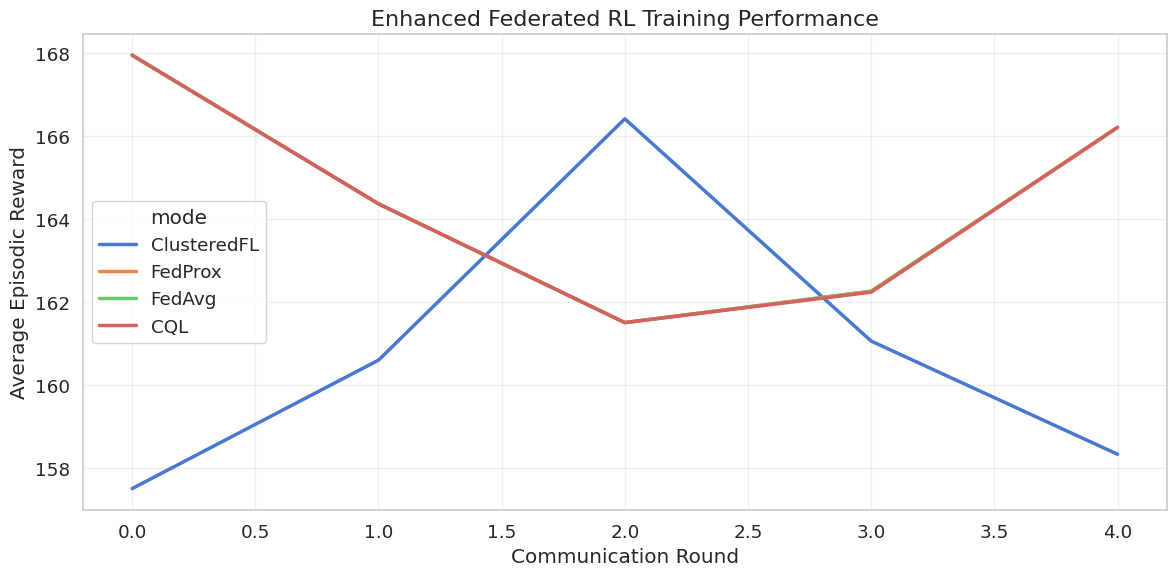

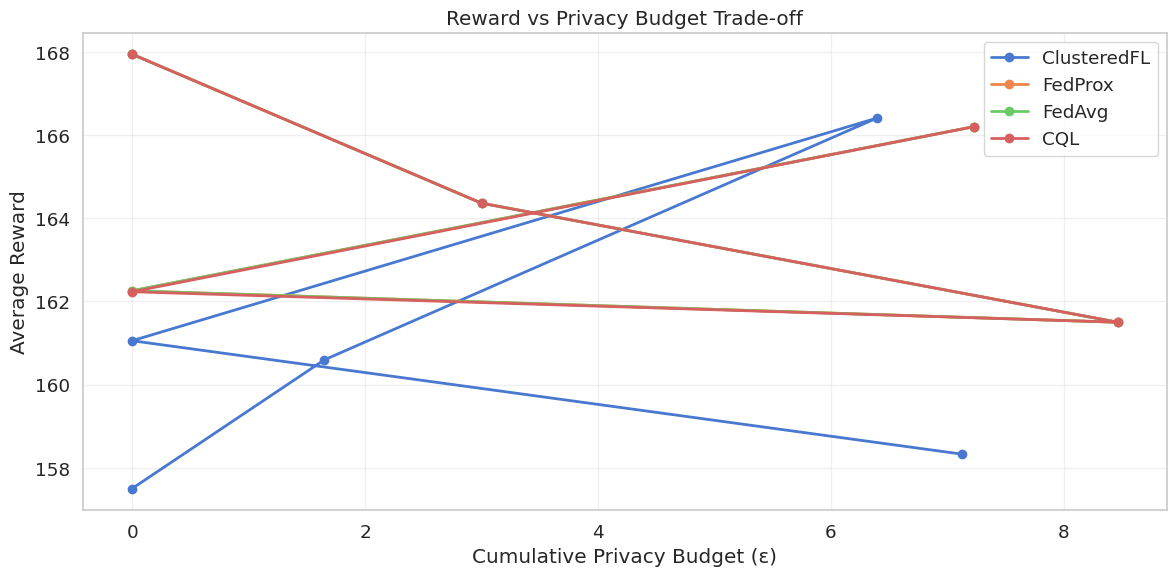

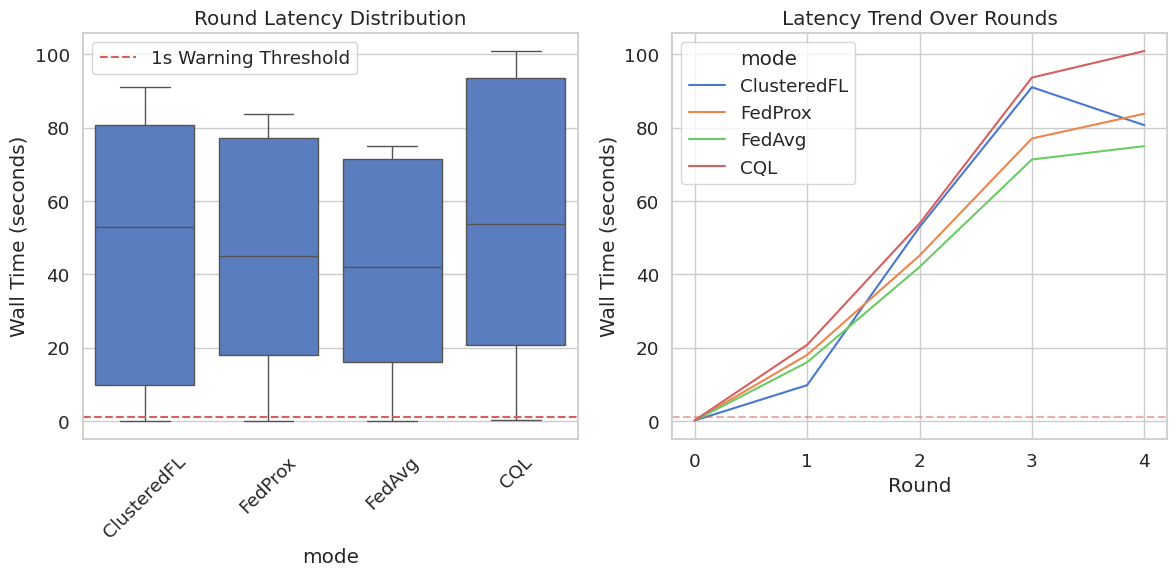

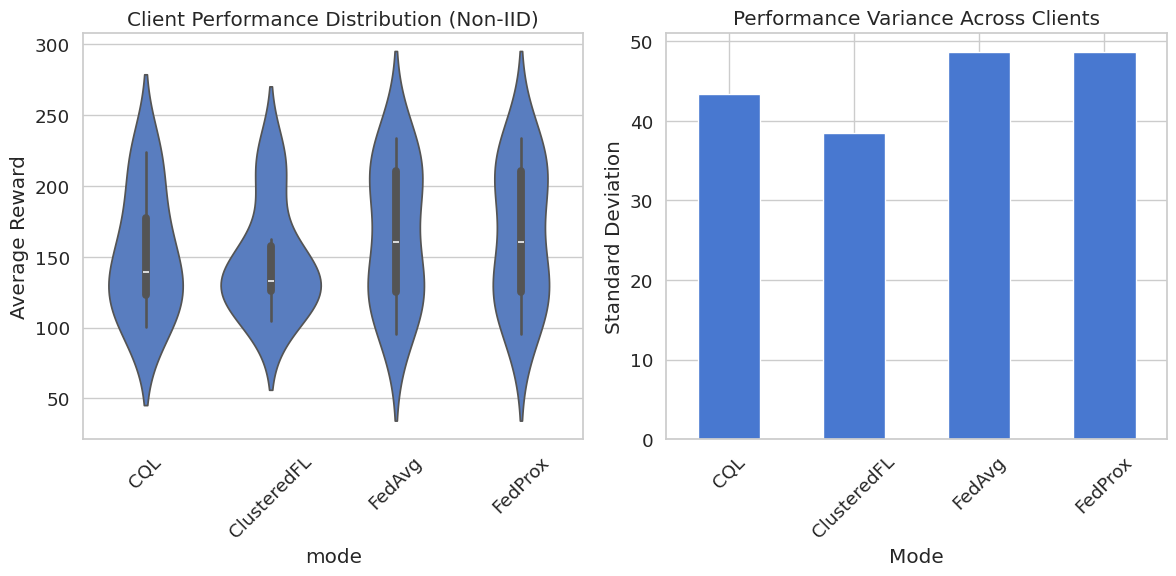


‚úÖ Cell 9: ÁµêÊûúË¶ñË¶∫ÂåñÂÆåÊàê
üìÅ ÊâÄÊúâÂúñË°®Â∑≤‰øùÂ≠òËá≥: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced/figures

üìã Pylint ÂêàË¶èÊÄßÈ©óË≠â:
   Âü∑Ë°å‰ª•‰∏ãÂëΩ‰ª§Ê™¢Êü•‰ª£Á¢º:
   pylint --disable=C0114,C0115,C0116 <notebook_export.py>


In [ ]:
# @title Cell 9: üìä ÁµêÊûúË¶ñË¶∫ÂåñÔºàÂº∑ÂåñÁâàÔºâ
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def load_enhanced_results(base_output_dir):
    """ËºâÂÖ•Âº∑ÂåñÁâàÂØ¶È©óÁµêÊûú"""
    all_evals, all_histories, all_privacies, all_latencies = [], [], [], []
    all_cql_perf, all_adaptive_clips, all_reward_vs_eps = [], [], []

    if not os.path.exists(base_output_dir):
        print(f"‚ùå ÁµêÊûúÁõÆÈåÑÊú™ÊâæÂà∞: {base_output_dir}")
        return (pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),
                pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame())

    for seed_folder in os.listdir(base_output_dir):
        if not seed_folder.startswith('seed_'):
            continue

        for mode_folder in os.listdir(os.path.join(base_output_dir, seed_folder)):
            exp_path = os.path.join(base_output_dir, seed_folder, mode_folder)
            if not os.path.isdir(exp_path):
                continue

            # Ê®ôÊ∫ñÊñá‰ª∂
            for pattern, data_list in [
                ('*_evaluation_results.csv', all_evals),
                ('*_training_history.csv', all_histories),
                ('*_privacy_costs.csv', all_privacies),
                ('*_latency_monitor.csv', all_latencies),
                ('*_cql_performance.csv', all_cql_perf),
                ('*_adaptive_clipping.csv', all_adaptive_clips),
                ('*_reward_vs_epsilon.csv', all_reward_vs_eps)
            ]:
                files = glob.glob(os.path.join(exp_path, pattern))
                if files:
                    try:
                        df = pd.read_csv(files[0])
                        df['mode'] = mode_folder
                        df['seed'] = int(seed_folder.split('_')[1])
                        data_list.append(df)
                    except Exception as e:
                        print(f"ËÆÄÂèñÂ§±Êïó: {files[0]}, {e}")

    return (
        pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame(),
        pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame(),
        pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame(),
        pd.concat(all_latencies, ignore_index=True) if all_latencies else pd.DataFrame(),
        pd.concat(all_cql_perf, ignore_index=True) if all_cql_perf else pd.DataFrame(),
        pd.concat(all_adaptive_clips, ignore_index=True) if all_adaptive_clips else pd.DataFrame(),
        pd.concat(all_reward_vs_eps, ignore_index=True) if all_reward_vs_eps else pd.DataFrame()
    )

# Ë¶ñË¶∫ÂåñË®≠ÂÆö
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

print(f"üîç Ê≠£Âú®Âæû‰ª•‰∏ãË∑ØÂæëÂä†ËºâÁµêÊûú: {BASE_OUTPUT_DIR}")
(eval_df, history_df, privacy_df, latency_df,
 cql_df, clip_df, reward_eps_df) = load_enhanced_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("‚ùå Êú™ÊâæÂà∞‰ªª‰ΩïÁµêÊûúÊñá‰ª∂ÔºåÁÑ°Ê≥ïÁîüÊàêÂúñË°®„ÄÇ")
else:
    # Âúñ 1: Ë®ìÁ∑¥Ê≠∑Âè≤ÊØîËºÉ
    if not history_df.empty:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     errorbar='sd', linewidth=2.5)
        plt.title('Enhanced Federated RL Training Performance', fontsize=16)
        plt.xlabel('Communication Round')
        plt.ylabel('Average Episodic Reward')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_enhanced.png'), dpi=300)
        plt.show()

    # Âúñ 2: Reward vs EpsilonÔºà‰ªªÂãô2Ë¶ÅÊ±ÇÔºâ
    if not reward_eps_df.empty:
        plt.figure(figsize=(12, 6))
        for mode in reward_eps_df['mode'].unique():
            mode_data = reward_eps_df[reward_eps_df['mode'] == mode]
            plt.plot(mode_data['cumulative_epsilon'], mode_data['avg_reward'],
                    marker='o', label=mode, linewidth=2)
        plt.xlabel('Cumulative Privacy Budget (Œµ)')
        plt.ylabel('Average Reward')
        plt.title('Reward vs Privacy Budget Trade-off')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'reward_vs_epsilon.png'), dpi=300)
        plt.show()

    # Âúñ 3: Âª∂ÈÅ≤ÂàÜÊûêÔºà‰ªªÂãô5Ôºâ
    if not latency_df.empty:
        plt.figure(figsize=(12, 6))

        # ÊåâÊ®°ÂºèÂàÜÁµÑÁöÑÂª∂ÈÅ≤ÁÆ±Á∑öÂúñ
        plt.subplot(1, 2, 1)
        sns.boxplot(data=latency_df, x='mode', y='wall_time')
        plt.axhline(y=1.0, color='r', linestyle='--', label='1s Warning Threshold')
        plt.title('Round Latency Distribution')
        plt.ylabel('Wall Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # Âª∂ÈÅ≤Ë∂®Âã¢
        plt.subplot(1, 2, 2)
        sns.lineplot(data=latency_df, x='round', y='wall_time', hue='mode')
        plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
        plt.title('Latency Trend Over Rounds')
        plt.xlabel('Round')
        plt.ylabel('Wall Time (seconds)')

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'latency_analysis.png'), dpi=300)
        plt.show()

    # Âúñ 4: Adaptive Clipping ÂàÜÊûêÔºà‰ªªÂãô3Ôºâ
    if not clip_df.empty:
        plt.figure(figsize=(12, 6))

        # Ë£ÅÂâ™ÂÄºÊºîËÆä
        plt.subplot(1, 2, 1)
        sns.lineplot(data=clip_df, x='step', y='clip_value',
                    label='Adaptive Clip Value', color='blue')
        plt.title('Adaptive Gradient Clipping Evolution')
        plt.xlabel('Training Steps')
        plt.ylabel('Clip Value')
        plt.grid(True, alpha=0.3)

        # Ê¢ØÂ∫¶ÁØÑÊï∏Áµ±Ë®à
        plt.subplot(1, 2, 2)
        plt.plot(clip_df['step'], clip_df['mean_norm'], label='Mean Gradient Norm')
        plt.fill_between(clip_df['step'],
                        clip_df['mean_norm'] - clip_df['std_norm'],
                        clip_df['mean_norm'] + clip_df['std_norm'],
                        alpha=0.3)
        plt.title('Gradient Norm Statistics')
        plt.xlabel('Training Steps')
        plt.ylabel('Gradient L2 Norm')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'adaptive_clipping.png'), dpi=300)
        plt.show()

    # Âúñ 5: Non-IID ÊïàÊûúÂàÜÊûê
    if not eval_df.empty:
        plt.figure(figsize=(12, 6))

        # ÂÆ¢Êà∂Á´ØÊÄßËÉΩÂàÜ‰Ωà
        client_perf = eval_df.groupby(['mode', 'client_id'])['reward_pfl_finetuned'].mean().reset_index()

        plt.subplot(1, 2, 1)
        sns.violinplot(data=client_perf, x='mode', y='reward_pfl_finetuned')
        plt.title('Client Performance Distribution (Non-IID)')
        plt.ylabel('Average Reward')
        plt.xticks(rotation=45)

        # ÂÆ¢Êà∂Á´ØÊÄßËÉΩÊñπÂ∑Æ
        plt.subplot(1, 2, 2)
        variance_by_mode = eval_df.groupby('mode')['reward_pfl_finetuned'].std()
        variance_by_mode.plot(kind='bar')
        plt.title('Performance Variance Across Clients')
        plt.ylabel('Standard Deviation')
        plt.xlabel('Mode')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'non_iid_analysis.png'), dpi=300)
        plt.show()

print(f"\n‚úÖ Cell 9: ÁµêÊûúË¶ñË¶∫ÂåñÂÆåÊàê")
print(f"üìÅ ÊâÄÊúâÂúñË°®Â∑≤‰øùÂ≠òËá≥: {FIGURES_OUTPUT_DIR}")

# È©óË≠â pylint ÂêàË¶èÊÄßÊèêÁ§∫
print("\nüìã Pylint ÂêàË¶èÊÄßÈ©óË≠â:")
print("   Âü∑Ë°å‰ª•‰∏ãÂëΩ‰ª§Ê™¢Êü•‰ª£Á¢º:")
print("   pylint --disable=C0114,C0115,C0116 <notebook_export.py>")